<h1>CE9010 Project</h1>
<h3>by Cassandra Tay, Lim Bang Jin, Tng Jun Wei</h3>

# Table of Contents <a name='Contents'></a>
1. [Introduction](#introduction)<br>
2. [Libraries](#libraries)<br>
3. [Data Acquisition](#data-acquisition)<br>
4. [Feature Engineering - Coordinates](#eng-1)<br>
5. [Data Cleaning](#data-clean)<br>
6. [Feature Engineering - Other Features](#eng-2)<br>
    6.1. [Evaluate the number of MRT and primary schools near each listing](#eng-21)<br>
    6.2. [Evaluate the age of each apartment](#eng-22)<br>
    6.3. [Other apartment-related features](#eng-23)<br>
7. [Data Exploration](#data-exploration)<br>
    7.1 [Investigating Outliers](#outlier)<br>
    7.2 [Univariate Analysis](#uni)<br>
    7.3 [Bivariate Analysis](#bi)<br>
8. [Data Preprocessing](#data-preprocess)<br>
9. [Data Analysis](#data-analysis)<br>
    9.1. [Linear Regression](#linreg)<br>
    9.2. [Ridge Regression](#ridge)<br>
    9.3. [RandomForestRegressor](#rf)<br>
    9.4. [GradientBoostingRegressor](#gb)<br>
    9.5. [KNeighborsRegressor](#knn)<br>
    9.6. [Stacking](#stacking)<br>
10. [Conclusion](#conclusion)<br>
11. [Future Work](#future-work)<br>

##  1. Introduction <a name='introduction'></a>
[Back to top](#Contents)<br>

<p>Introduction and motivation. The data science PROBLEM to solve. </p>

## 2. Libraries <a name='libraries'></a>
[Back to top](#Contents)<br>

<p> Please setup a virtual conda environment and do conda install for these libraries:<br>
    <ul>
        <li>Python 3.6</li>
        <li>Numpy</li>
        <li>Pandas</li>
        <li>Matplotlib</li>
        <li>Seaborn</li>
        <li>Scikit-learn</li>
        <li>Geopandas</li>
        <li>Shapefile</li>
        <li>Descartes</li>
        <li>Geopy</li>
    </ul>

In [2]:
# libraries 
import pandas as pd
import numpy as np 
import warnings
import pickle

# geographical distance 
from geopy.distance import distance

# visualization tools 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import shapefile as shp
import descartes

# machine learning
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor

warnings.filterwarnings("ignore", category=RuntimeWarning)

## 3. Data Acquisition <a name='data-acquisition'></a>
[Back to top](#Contents)<br>

<p>Data acquisition, how is it done, etc.</p>

<p>File obtained: property_raw_data.xlsx, property_raw_data.json

## 4. Feature Engineering - Coordinates <a name='eng-1'></a>
[Back to top](#Contents)<br>

<p>How is it done?</p>

<p>File obtained: property_loc.csv

# 5. Data Cleaning 
[Back to top](#Contents)<br>
<br>

The acquired data contains the following features: 
1. Address 
2. Building Name 
3. Built On - Year that the building was built 
4. Land Area - Size of the house 
5. No. of Bathroom 
6. No. of Bedroom 
7. Price 
8. Price per sqft 
9. Tenure 
10. Type of property 
11. Latitude
12. Longtitude 


The data cleaning was conducted in the following process: 
1. Eliminate missing values and values that contain unknown data (e.g unknown tenure). 
2. Remove uncommon houses like shophouse and convervation house from the dataset (as there are insufficient data to train the model for such type of houses)
3. Remove string symbols like 'S$', 'psf', 'sqft' 
4. Extract numeric value from the 'Land_Area' variable 

In [2]:
data = pd.read_csv('data/property_loc.csv',delimiter =',', index_col=0)
data.head()

,Address,Building Name,Built On,Land Area,Number of Bathroom,Number of Bedroom,Price,Price per sqft,Tenure,Type,latitude,longitude
0,190 Bukit Batok West Avenue 6,190 Bukit Batok West Avenue 6,1995,1270 sqft,2,3,"S$ 546,000",S$ 429.92 psf,99-year Leasehold,HDB Apartment,1.345383,103.746046
1,Sims Drive,Sims Urban Oasis,99-year Leasehold,409 sqft,1,1,"S$ 720,000","S$ 1,760.39 psf",Condominium,New Project: 2020,1.318261,103.879391
2,57 Choa Chu Kang Loop,The Warren,2004,1066 sqft,2,2,"S$ 980,000",S$ 919.32 psf,99-year Leasehold,Condominium,1.386702,103.743679
3,21 Fernvale Road,High Park Residences,99-year Leasehold,680 sqft,2,2,"S$ 880,000","S$ 1,294.12 psf",Condominium,New Project: 2019,1.396440,103.875251
4,21 Nathan Road,Nathan Suites,2014,926 sqft,2,2,"S$ 2,500,000","S$ 2,699.78 psf",Freehold,Condominium,1.295316,103.827096


<p> First, we dropped the features that are not useful, and a few of the data points with missing values. We dropped the feature <b>"Price"</b> too as it is just equal to the product of area and price per sqft. We also renamed some of the features. </p>

In [3]:
data.drop(['Address', 'Building Name', 'Tenure', 'Price'], axis=1, inplace=True) #drop variables that are not useful 
data = data.rename(columns={"Built On": "Built", "Land Area": "area", "Number of Bathroom": "bathroom"
                          , "Number of Bedroom":"bedroom", "Price per sqft": "price_sqft"}) #simplify the variable names 
house = data.dropna() #drop missing values
house.head()

,Built,area,bathroom,bedroom,price_sqft,Type,latitude,longitude
0,1995,1270 sqft,2,3,S$ 429.92 psf,HDB Apartment,1.345383,103.746046
1,99-year Leasehold,409 sqft,1,1,"S$ 1,760.39 psf",New Project: 2020,1.318261,103.879391
2,2004,1066 sqft,2,2,S$ 919.32 psf,Condominium,1.386702,103.743679
3,99-year Leasehold,680 sqft,2,2,"S$ 1,294.12 psf",New Project: 2019,1.396440,103.875251
4,2014,926 sqft,2,2,"S$ 2,699.78 psf",Condominium,1.295316,103.827096


In [4]:
print('Number of data points: ', house.shape[0])
print("Number of features: ", house.shape[1])

Number of data points:  8546
Number of features:  8


Next, we removed non-numeric values from the 'Built' variable as we need the numeric value to obtain a new variable (Building Age) 

In [5]:
a = house.loc[:, ('Built')].str.isnumeric()
house = house.drop(house.index[a == False])
house['Built'].astype('int64')

0       1995
2       2004
4       2014
8       2019
9       2008
        ... 
9158    2006
9160    1986
9161    1999
9162    1999
9163    2010
Name: Built, Length: 7339, dtype: int64

Since we are only looking at apartments, we removed house types that are not <b>HDB </b> and <b>Condo</b>.

In [6]:
house.Type = house.Type.str.replace('Condominium', 'Condo').replace('Apartment', 'Condo').replace('Executive Condo','Condo').replace('Walk-up','Condo')
house.Type = house.Type.str.replace('HDB Apartment', 'HDB')

mask = (house['Type'] != 'HDB') & (house['Type'] != 'Condo')
house.drop(house[mask].index, inplace=True)

We dropped the '$', 'S'  and 'psf' from the price features.

In [8]:
house['price_sqft'] = house['price_sqft'].replace({'S':' ', 'psf':' ',',': ''}, regex=True)
house['price_sqft'] = house['price_sqft'].str.replace('$', '')
house['price_sqft'] = house['price_sqft'].astype(float)

We dropped the '$', 'S','land' and 'sqft' to make the variables to be float value

In [9]:
house['area'] = house['area'].replace({'sqft':' ', 'land':' '}, regex=True)
house['area'] = house['area'].str.replace('(', '')
house['area'] = house['area'].str.replace(')', '')
house['area'] = house['area'].astype(float)

In [10]:
house.reset_index(inplace=True, drop=True)
print('Number of data points: ', house.shape[0])
print("Number of features: ", house.shape[1])

house.head()

Number of data points:  6771
Number of features:  8


,Built,area,bathroom,bedroom,price_sqft,Type,latitude,longitude
0,1995,1270.0,2,3,429.92,HDB,1.345383,103.746046
1,2004,1066.0,2,2,919.32,Condo,1.386702,103.743679
2,2014,926.0,2,2,2699.78,Condo,1.295316,103.827096
3,2008,668.0,1,1,1871.26,Condo,1.280772,103.852660
4,2000,1959.0,4,4,2118.43,Condo,1.313388,103.827361


In [11]:
house.to_csv('data/data_cleaned.csv', index=False)

## 6. Feature Engineering - Other Features <a name='eng-2'></a>
[Back to top](#Contents)<br>

From the coordinates of the apartments, we can engineer a few features to better allow our models to predict the prices.

### 6.1 Evaluate the number of MRT and primary schools near each listing <a name='eng-21'></a>

We obtained two files, <b>school.csv</b> and <b>mrt.csv</b>.

They contain the coordinates of primary schools and MRT stations respectively. From these two files, we can get the number of MRT stations and primary schools near each listing, using the <b>geopy</b> package.

The source for <b>mrt.csv</b> is <a>https://www.kaggle.com/yxlee245/singapore-train-station-coordinates</a>.
The file <b>school.csv</b> is by courtesy of Cassandra.

In [70]:
house = pd.read_csv('data/data_cleaned.csv')

In [71]:
# helper function to calculate distance between two points
# function not vector-friendly due to 'geopy.distance'
def facilities(coord,house_coord,dis):
    nearby= np.zeros(len(house_coord))[:,None]
    for i in range(len(house_coord)):
        count = 0
        for j in range(len(coord)):
            cal = distance(house_coord[i],coord[j]).m
            if cal <= dis:
                count +=1        
        nearby[i]= count
    return nearby

For MRT station, we define nearby as 500m within range, as it is a reasonable distance for a commuting person.


For primary schools, we define a range of 1km distance instead. This is important for some primary school with more registrants than vacancies, as there would be priority admission be given based on the child's citizenship and home-to-school distance. The first priority is given to students living within 1km of the school. 

In [72]:
mrt = pd.read_csv('data/mrt.csv')
school = pd.read_csv('data/school.csv')

school.drop(columns=['name'], inplace=True)
mrt.drop(columns=['station_name', 'type'], inplace=True)

house_coord = np.array(house[['latitude', 'longitude']])
mrt_coord = np.array(mrt)
sch_coord = np.array(school)

nearby_mrt = facilities(mrt_coord,house_coord,500)
nearby_sch = facilities(sch_coord, house_coord, 1000)

### 6.2 Evaluate the age of each apartment <a name='eng-22'></a>

We extract the age of the apartment, instead of using the year of construction.

In [73]:
built_on = house['Built'].astype(int)
age_of_building = (2020 - built_on)[:,None]
house.drop(columns=['Built'], inplace=True)

### 6.3 Other apartment-related features <a name='eng-23'></a>

We define a few other features related to the apartment, such as total bathroom area, total bedroom area, remaining living area, and a convenience score (MRT + School). Then, we add the engineered features to the housing data.

In [74]:
# Helper function to calculate distance between two coordinates
def dist_bet_coords(x):
    orchard = (1.303991, 103.831782)
    place2_coords = (x.latitude, x.longitude)
    return distance(orchard, place2_coords).km


house['school'] = nearby_sch
house['mrt'] = nearby_mrt
house['age_of_building'] = age_of_building
house['bathroom_area'] = 0.05 * house['bathroom'] * house['area']
house['bedroom_area'] = 0.125 * house['bedroom'] * house['area']
house['remaining_area'] = house['area'] - house['bathroom_area'] - house['bedroom_area']
house['convenience'] = house['mrt'] + house['school']
house['distance_from_central'] = house.apply(dist_bet_coords, axis = 1)

In [75]:
house = house[[c for c in house if c not in ['price_sqft']] + ['price_sqft']]
print("Number of features: ", house.shape[1])
house.head()

Number of features:  15


,area,bathroom,bedroom,Type,latitude,longitude,school,mrt,age_of_building,bathroom_area,bedroom_area,remaining_area,convenience,distance_from_central,price_sqft
0,1270.0,2,3,HDB,1.345383,103.746047,3.0,0.0,25,127.0,476.25,666.75,3.0,10.582454,429.92
1,1066.0,2,2,Condo,1.386702,103.743679,3.0,1.0,16,106.6,266.50,692.90,4.0,13.408199,919.32
2,926.0,2,2,Condo,1.295316,103.827096,1.0,0.0,6,92.6,231.50,601.90,1.0,1.091837,2699.78
3,668.0,1,1,Condo,1.280772,103.852660,0.0,3.0,12,33.4,83.50,551.10,3.0,3.462779,1871.26
4,1959.0,4,4,Condo,1.313388,103.827361,1.0,0.0,20,391.8,979.50,587.70,1.0,1.149650,2118.43


In [76]:
house.to_csv('data/data_eng.csv', index=False)

## 7. Data Exploration <a name='data-exploration'></a>
[Back to top](#Contents)<br>

In [3]:
house = pd.read_csv('data/data_eng.csv')

In [4]:
hdb = house[house.Type == 'HDB']
print('The dimension of the HDB subset data: ', hdb.shape)
print()
hdb.describe()

The dimension of the HDB subset data:  (2636, 15)



,area,bathroom,bedroom,price_sqft,latitude,longitude,school,mrt,age_of_building,bathroom_area,bedroom_area,remaining_area,convenience,distance_from_central
count,2.636000e+03,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000
mean,1.871308e+03,1.987102,2.949165,494.886191,1.361176,103.854876,3.191199,0.322838,25.877086,185.982872,782.855463,902.470087,3.514036,10.452075
std,3.411312e+04,0.383513,0.626786,312.093437,0.040932,0.068448,1.891119,0.515515,14.522066,3402.350722,17002.241211,13763.003482,1.945801,3.978862
min,5.900000e+01,1.000000,1.000000,0.310000,1.271745,103.686700,0.000000,0.000000,4.000000,2.950000,14.750000,-46.025000,0.000000,1.527764
25%,9.157500e+02,2.000000,3.000000,385.657500,1.332780,103.809744,2.000000,0.000000,9.000000,91.300000,339.000000,508.200000,2.000000,7.580836
50%,1.098000e+03,2.000000,3.000000,442.235000,1.359342,103.865756,3.000000,0.000000,27.000000,109.800000,411.750000,536.550000,3.000000,11.381168
75%,1.291000e+03,2.000000,3.000000,525.297500,1.390608,103.904622,4.000000,1.000000,37.000000,129.100000,484.500000,632.625000,5.000000,13.668415
max,1.744612e+06,9.000000,7.000000,5208.330000,1.457100,103.987494,10.000000,5.000000,83.000000,174461.200000,872306.000000,697844.800000,10.000000,19.719809


In [5]:
condo = house[house.Type == 'Condo']
print('\nThe dimension of the Condo subset data: ', condo.shape)
condo.describe()


The dimension of the Condo subset data:  (4135, 15)


,area,bathroom,bedroom,price_sqft,latitude,longitude,school,mrt,age_of_building,bathroom_area,bedroom_area,remaining_area,convenience,distance_from_central
count,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000
mean,1671.920919,2.362999,2.557437,1564.518283,1.331082,103.856650,1.743652,0.527207,9.842563,225.819323,615.519710,830.581886,2.270859,7.569200
std,17757.486328,1.050507,1.001222,688.358174,0.040792,0.059382,1.613492,0.741129,8.619328,1787.658841,6197.246585,9913.822449,1.668647,4.832102
min,344.000000,1.000000,1.000000,1.010000,1.239651,103.661390,0.000000,0.000000,-4.000000,17.200000,43.000000,-1094.625000,0.000000,0.018692
25%,807.000000,2.000000,2.000000,1088.545000,1.300710,103.822690,1.000000,0.000000,4.000000,76.400000,193.750000,491.400000,1.000000,3.355834
50%,1098.000000,2.000000,3.000000,1419.350000,1.320475,103.852660,1.000000,0.000000,7.000000,116.200000,373.750000,585.750000,2.000000,7.090569
75%,1453.000000,3.000000,3.000000,1882.915000,1.359743,103.900873,2.000000,1.000000,14.000000,206.700000,573.375000,685.750000,3.000000,11.646675
max,990000.000000,8.000000,7.000000,12799.530000,1.449767,103.993110,10.000000,4.000000,83.000000,99000.000000,371250.000000,519750.000000,11.000000,19.379355


Based on the descriptive data, there seems to be a large difference between the maximum value and the 75% quantile for the variables. Hence, we would like to plot the boxplots for each variable to check for outliers and remove them. 

### 7.1. Investigating Outliers <a name='outlier'></a>
[Back to top](#Contents)<br>

All the property stated in data can be categorised into 2 different property: HDB and Condo. Based on the boxplot below, there are quite a number of outliers. Therefore, we would need to remove the outliers.

In [6]:
#create a function to remove the outliers
def outliers(col, df):
    df.reset_index(inplace=True,drop=True)
    iqr = df[col].quantile(0.75)-df[col].quantile(0.25) #find the iqr
    Upperb = df[col].quantile(0.75) + 1.5*iqr #find the upper and lower bound
    Lowerb = df[col].quantile(0.25) - 1.5*iqr 
    upper_outliers = (df[col] < Upperb) #true if the value lies within the boundary 
    df = df.drop(df.index[upper_outliers==False]) #remove if the value is false
    if sum(df[col] < Lowerb) == 0: #check if there is any outliers falling below the lower boundary, if 0, we have removed all the outliers 
        return df
    else:
        df.reset_index(inplace=True,drop=True) 
        Lower_outliers = (df[col] > Lowerb)
        df = df.drop(df.index[Lower_outliers==False])
        return df

### Features: Price_sqft and Area

Text(0.5, 1.0, 'Box plot for Condo Price_per_sqft')

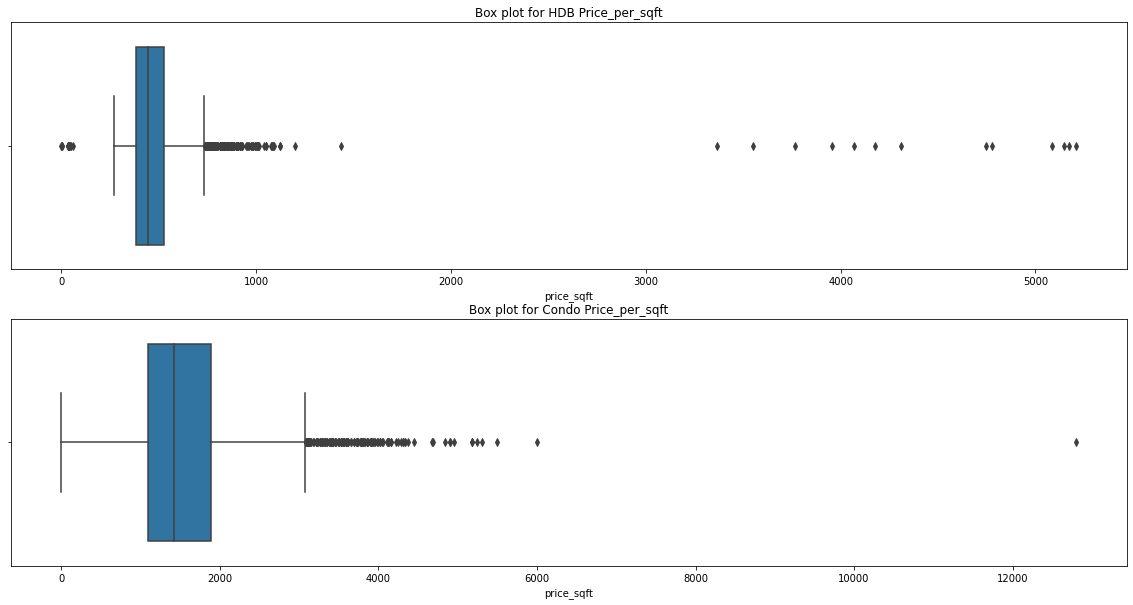

In [7]:
#box plot for significant variable "price_sqft"
f, axes = plt.subplots(2, 1,figsize=(20,10))

sns.boxplot(x='price_sqft', data=hdb, ax=axes[0])
axes[0].set_title("Box plot for HDB Price_per_sqft")
sns.boxplot(x='price_sqft', data=condo, ax=axes[1])
axes[1].set_title("Box plot for Condo Price_per_sqft")

Text(0.5, 1.0, 'Box plot for Condo Land_Area')

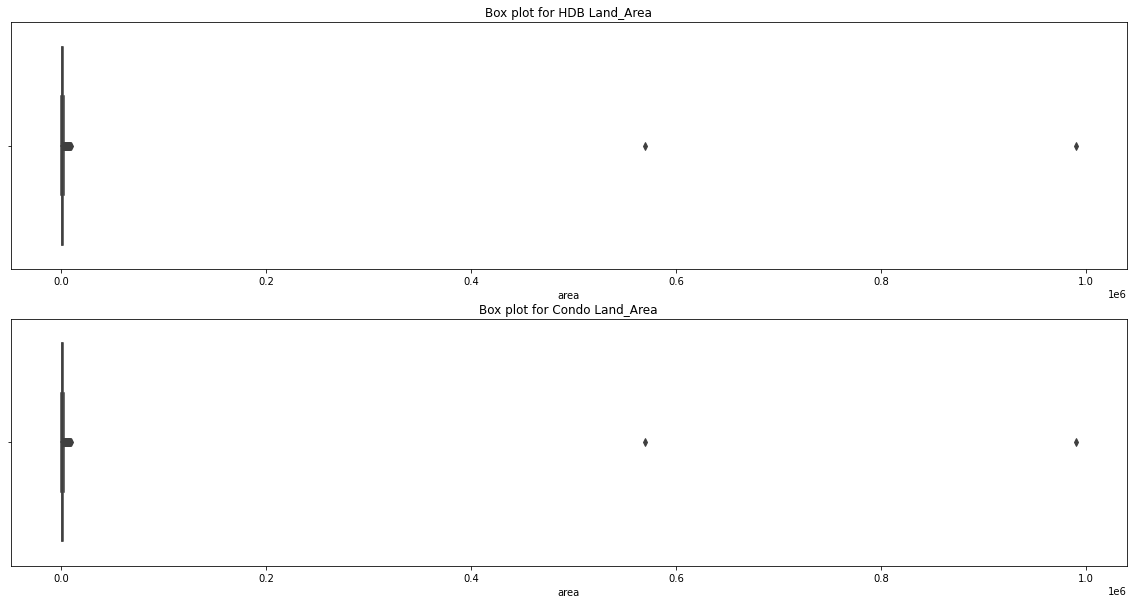

In [8]:
#box plot for significant variable "area"
f, axes = plt.subplots(2, 1,figsize=(20,10))

sns.boxplot(x='area', data=condo, ax=axes[0])
axes[0].set_title("Box plot for HDB Land_Area")
sns.boxplot(x='area', data=condo, ax=axes[1])
axes[1].set_title("Box plot for Condo Land_Area")

We removed outliers for variables like "area" and "price_sqft" as those values have great differences in the summary statistics.

In [9]:
hdb = outliers("area", hdb)
hdb = outliers("price_sqft", hdb)

condo = outliers("area", condo)
condo = outliers("price_sqft", condo)

print("The dimension of the HDB data is: ", hdb.shape)
print("The dimension of the Condo data is: ", condo.shape)

The dimension of the HDB data is:  (2426, 15)
The dimension of the Condo data is:  (3725, 15)


We plot the boxplots without the outliers.

Text(0.5, 1.0, 'Box plot for Condo Price_per_sqft')

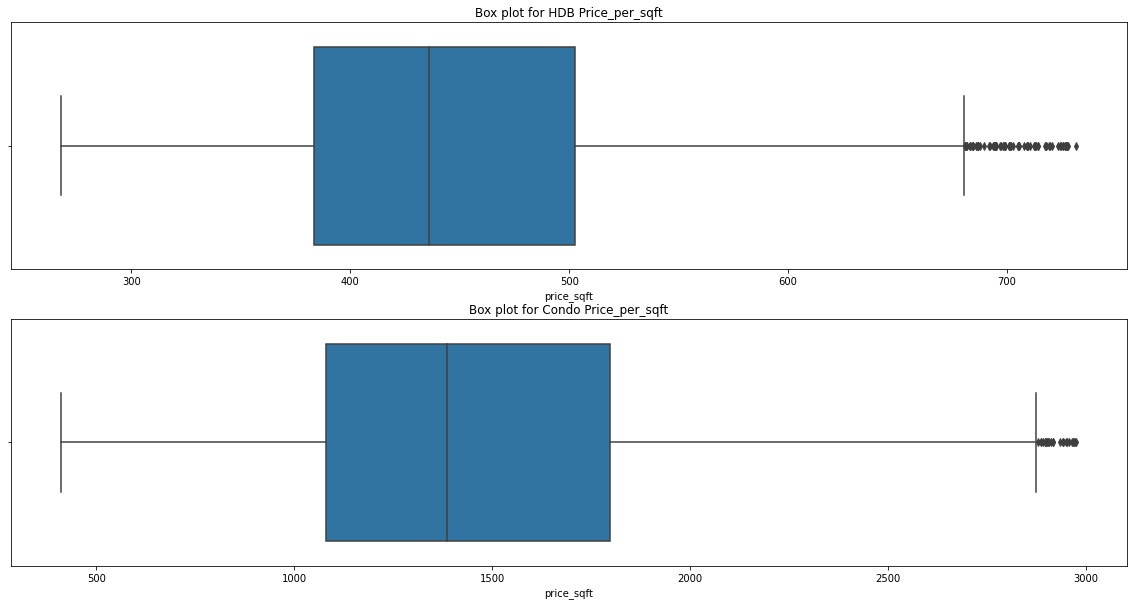

In [10]:
f, axes = plt.subplots(2, 1,figsize=(20,10))

sns.boxplot(x='price_sqft', data=hdb, ax=axes[0])
axes[0].set_title("Box plot for HDB Price_per_sqft")
sns.boxplot(x='price_sqft', data=condo, ax=axes[1])
axes[1].set_title("Box plot for Condo Price_per_sqft")

Text(0.5, 1.0, 'Box plot for Condo Land_Area')

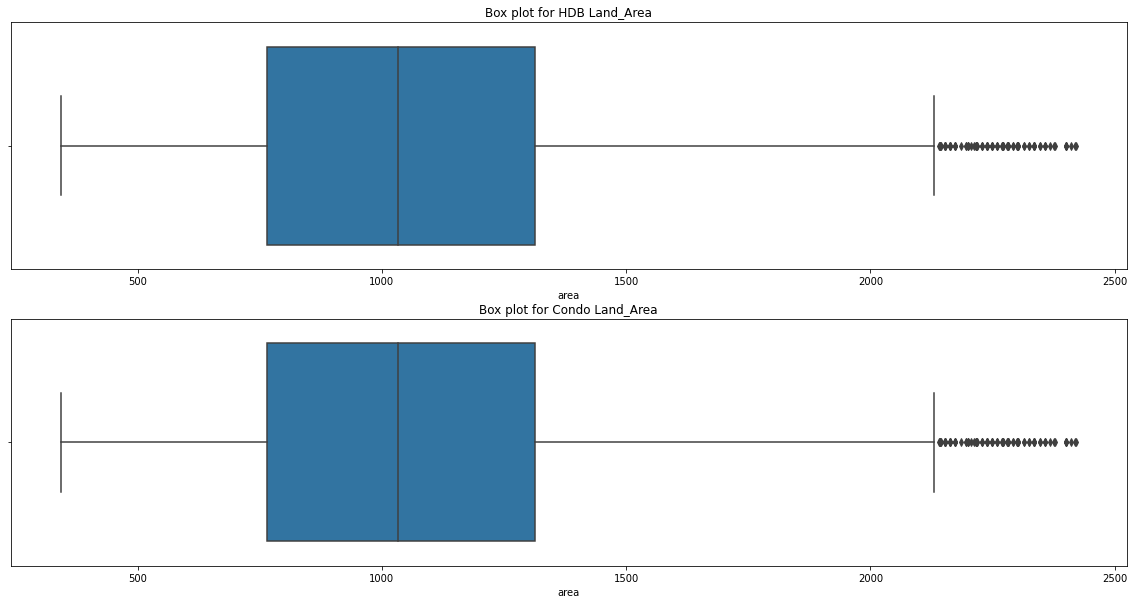

In [11]:
f, axes = plt.subplots(2, 1,figsize=(20,10))

sns.boxplot(x='area', data=condo, ax=axes[0])
axes[0].set_title("Box plot for HDB Land_Area")
sns.boxplot(x='area', data=condo, ax=axes[1])
axes[1].set_title("Box plot for Condo Land_Area")

### Investigation for other variables 

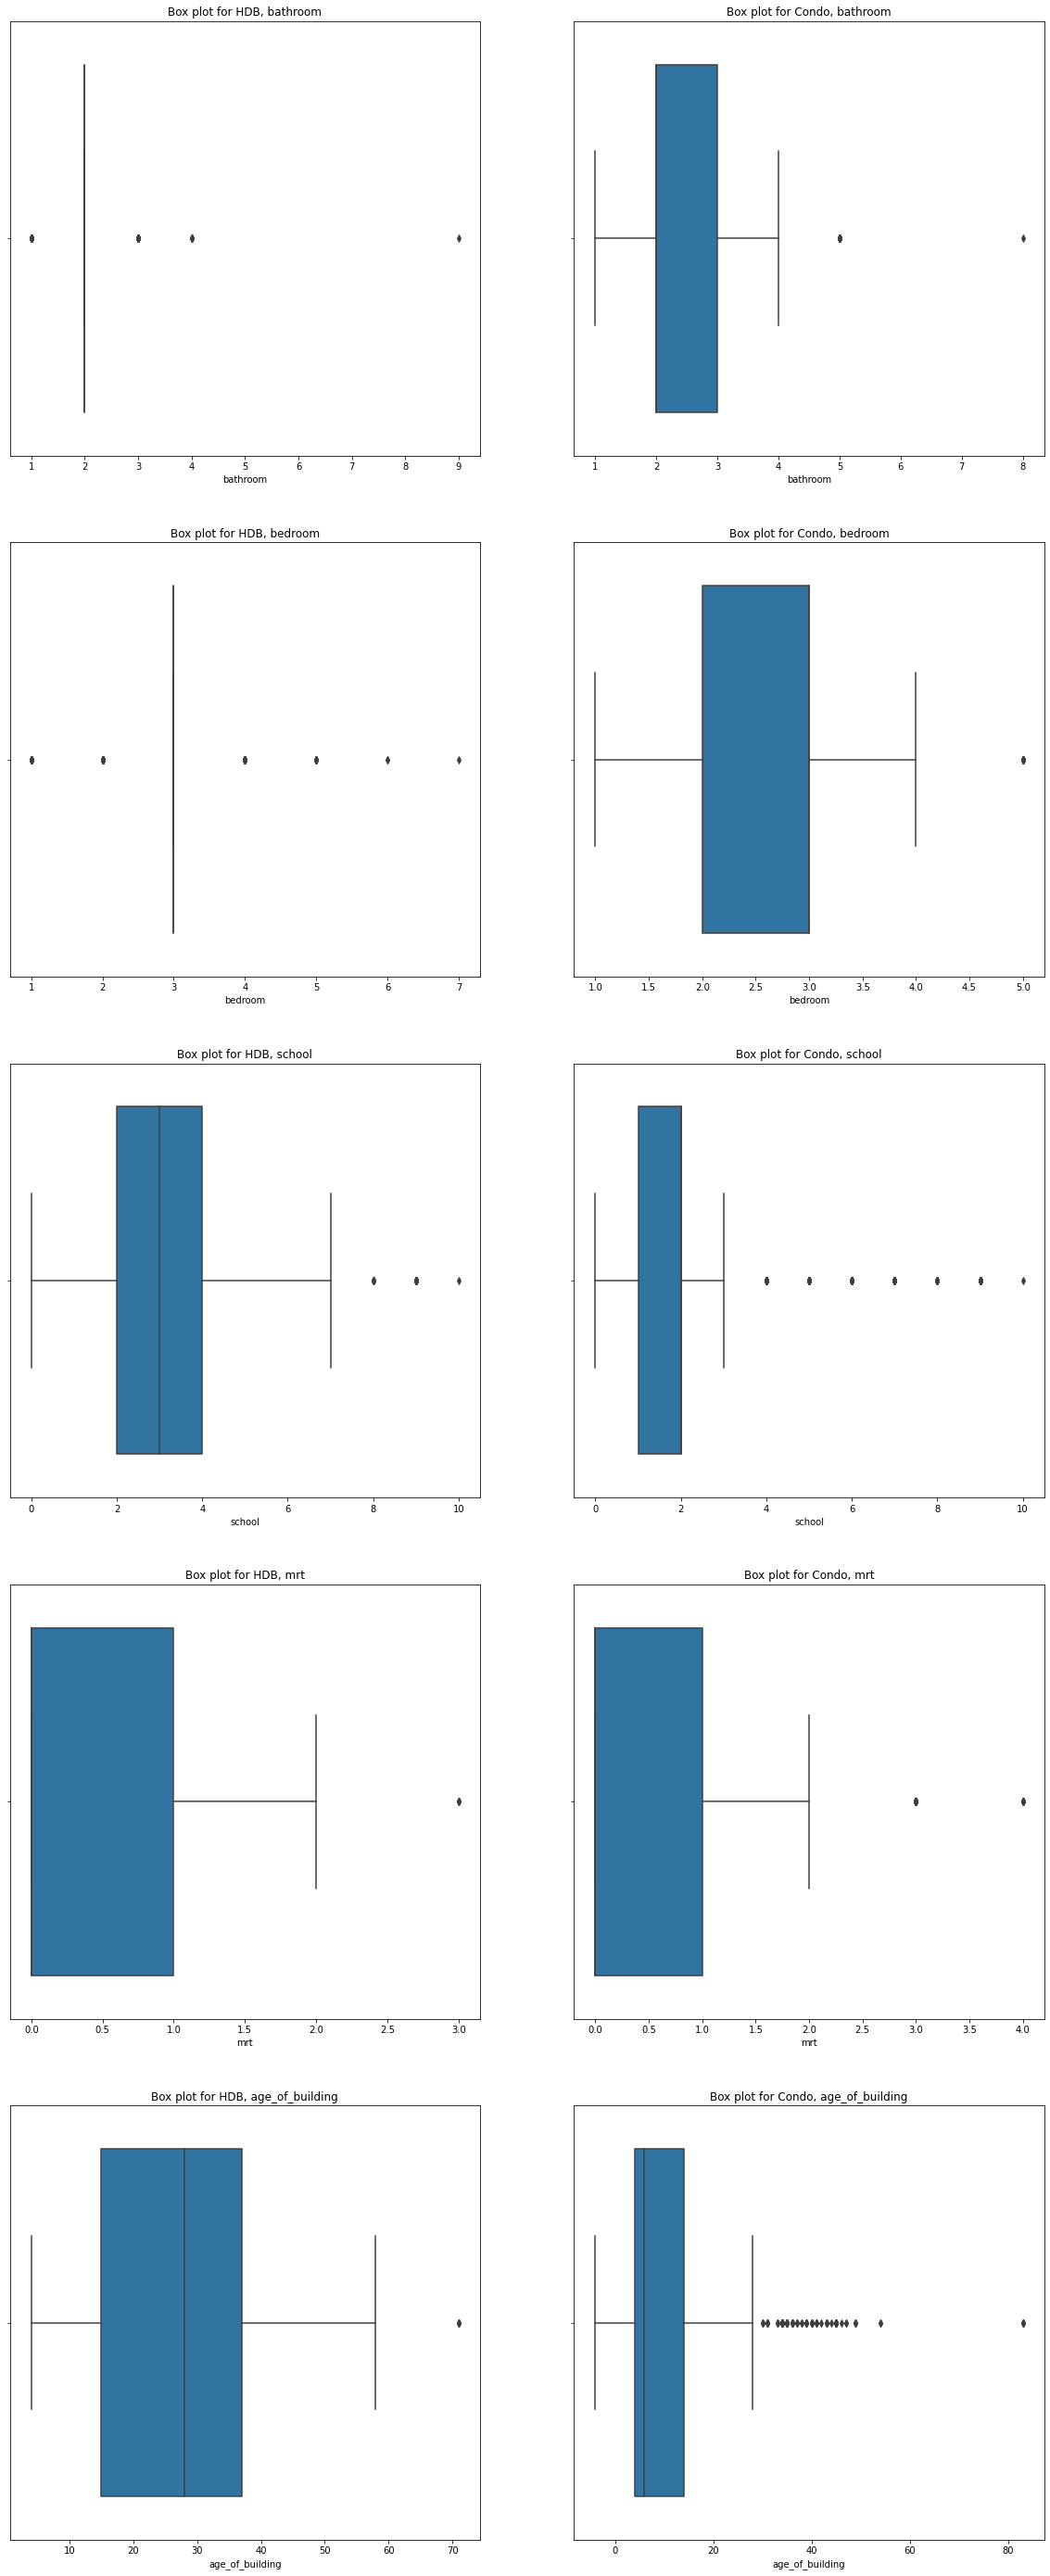

In [31]:
f, axes = plt.subplots(5, 2,figsize=(20,50))

to_plot = ['bathroom', 'bedroom', 'school', 'mrt', 'age_of_building']

for i in range(len(to_plot)):
    sns.boxplot(x=to_plot[i], data=hdb, ax=axes[i][0])
    axes[i][0].set_title("Box plot for HDB, {}".format(to_plot[i]))
    
    sns.boxplot(x=to_plot[i], data=condo, ax=axes[i][1])
    axes[i][1].set_title("Box plot for Condo, {}".format(to_plot[i]))
    
    i += 1

In [14]:
data = pd.concat([hdb,condo]) #combine the two datasets together 
print("The dimension of the listing data: ", data.shape)
data.head()

The dimension of the listing data:  (6151, 15)


,area,bathroom,bedroom,price_sqft,Type,latitude,longitude,school,mrt,age_of_building,bathroom_area,bedroom_area,remaining_area,convenience,distance_from_central
0,1270.0,2,3,429.92,HDB,1.345383,103.746046,3.0,0.0,25,127.0,476.250,666.750,3.0,10.582454
1,1270.0,2,3,533.86,HDB,1.373571,103.851554,2.0,1.0,40,127.0,476.250,666.750,3.0,8.002258
2,990.0,2,2,459.60,HDB,1.315350,103.770855,2.0,0.0,43,99.0,247.500,643.500,2.0,6.895952
3,1400.0,2,3,371.43,HDB,1.448271,103.813344,4.0,0.0,21,140.0,525.000,735.000,4.0,16.085163
4,905.0,2,3,386.74,HDB,1.372392,103.889038,6.0,1.0,35,90.5,339.375,475.125,7.0,9.889811


### 7.2. Univariate Analysis <a name='uni'></a>
[Back to top](#Contents)<br>

In [33]:
data.describe() #provide the descriptive statistics

,area,bathroom,bedroom,price_sqft,latitude,longitude,school,mrt,age_of_building,bathroom_area,bedroom_area,remaining_area,convenience,distance_from_central
count,6151.000000,6151.000000,6151.000000,6151.000000,6151.000000,6151.000000,6151.00000,6151.000000,6151.000000,6151.000000,6151.000000,6151.000000,6151.000000,6151.000000
mean,1092.586571,2.107950,2.626565,1070.507831,1.345566,103.857973,2.40026,0.434401,16.497155,125.083507,388.281174,579.221891,2.834661,9.053204
std,373.078806,0.726762,0.845381,640.218693,0.043084,0.063993,1.88949,0.662746,13.895497,80.768301,223.534663,128.092872,1.907233,4.590882
min,344.000000,1.000000,1.000000,268.010000,1.239651,103.661390,0.00000,0.000000,-4.000000,17.200000,43.000000,-46.025000,0.000000,0.246289
25%,818.000000,2.000000,2.000000,464.650000,1.311579,103.820063,1.00000,0.000000,6.000000,79.600000,209.750000,496.600000,2.000000,4.507864
50%,1055.000000,2.000000,3.000000,982.080000,1.344132,103.857858,2.00000,0.000000,11.000000,108.700000,375.375000,565.200000,3.000000,9.899421
75%,1302.000000,2.000000,3.000000,1504.740000,1.377166,103.903020,3.00000,1.000000,25.000000,152.800000,488.250000,643.500000,4.000000,12.984980
max,2421.000000,9.000000,7.000000,2975.100000,1.457100,103.993110,10.00000,4.000000,83.000000,605.000000,1610.875000,1308.450000,11.000000,19.719809


Based on the above statistical analysis, the mean pricing per area for Singapore houses are around SGD <b>1070</b> per sqft and the median pricing are around SGD <b>982</b> per sqft. The reasons for the difference, might be attributed to higher Condo listings percentage compared to the HDB listings, hence the mean would be higher as Condo listings are generally more expensive than HDB.

Therefore, to understand the statistical analysis for the different features, we need to split the data according to the type of housing, namely HDB and Condo.

### Condo vs HDB

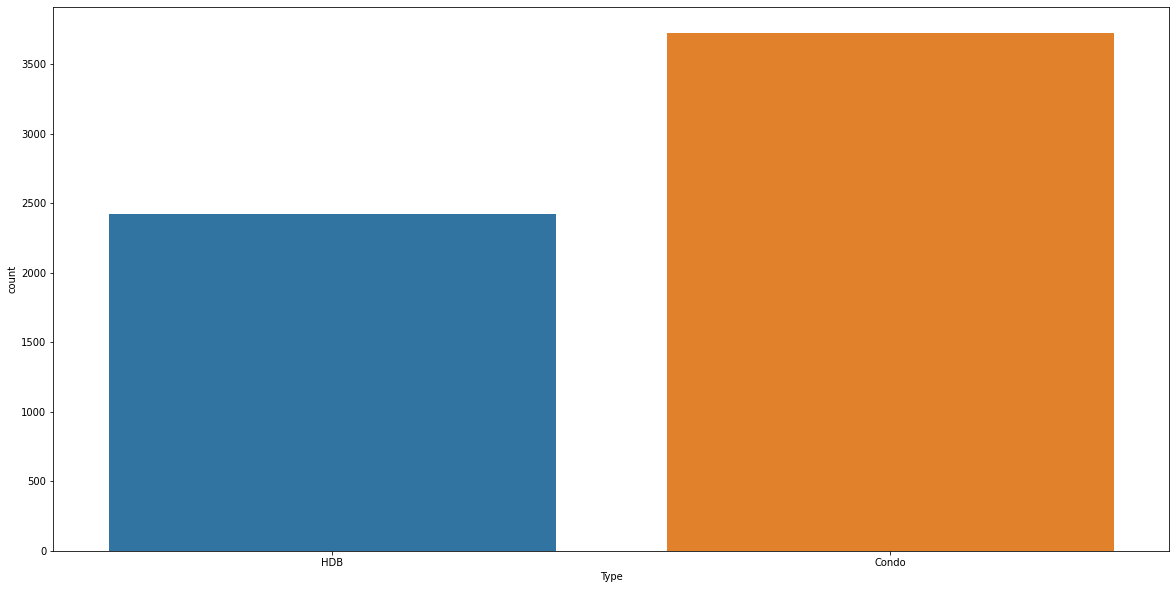

In [16]:
f,axes = plt.subplots(1,1,figsize=(20,10))
sns.countplot(x='Type', data=data, ax=axes)

In [17]:
No_of_housing = data.shape[0]
No_of_HDB_housing = np.sum(data["Type"]=="HDB")
No_of_Condo_housing = np.sum(data["Type"]=="Condo")
p_HDB = (No_of_HDB_housing/No_of_housing)*100
p_condo = (No_of_Condo_housing/No_of_housing)*100
print("The number of HDB housing is ", No_of_HDB_housing)
print("The percentage of HDB housing is", round(p_HDB,2), '%')
print()
print("The number of Condo housing is ", No_of_Condo_housing)
print("The percentage of Condo housing is", round(p_condo,2) , '%')

The number of HDB housing is  2426
The percentage of HDB housing is 39.44 %

The number of Condo housing is  3725
The percentage of Condo housing is 60.56 %


There seems to be 1.5x as many Condo listings as HDB listings.

### Analysis based on the Type of housing 

In [34]:
# Price analysis by house type
hdb = data[data['Type'] == 'HDB']
hdb.describe()

,area,bathroom,bedroom,price_sqft,latitude,longitude,school,mrt,age_of_building,bathroom_area,bedroom_area,remaining_area,convenience,distance_from_central
count,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000
mean,1100.823578,1.983924,2.944353,452.210602,1.363906,103.857408,3.282358,0.304204,26.782770,111.823454,420.999382,568.000742,3.586562,10.744589
std,267.251426,0.383351,0.613756,93.088412,0.039416,0.068923,1.904264,0.500514,14.205742,42.456274,171.827749,94.264815,1.972002,3.792426
min,430.000000,1.000000,1.000000,268.010000,1.271745,103.686700,0.000000,0.000000,4.000000,21.500000,53.750000,-46.025000,0.000000,1.527764
25%,968.000000,2.000000,3.000000,383.600000,1.336185,103.817860,2.000000,0.000000,15.000000,95.800000,355.125000,510.900000,2.000000,7.952996
50%,1108.000000,2.000000,3.000000,435.860000,1.364814,103.871923,3.000000,0.000000,28.000000,110.800000,415.500000,546.175000,3.000000,11.561879
75%,1291.000000,2.000000,3.000000,502.462500,1.392197,103.905940,4.000000,1.000000,37.000000,129.100000,488.250000,632.625000,5.000000,13.668488
max,1841.000000,9.000000,7.000000,731.500000,1.457100,103.987494,10.000000,3.000000,71.000000,542.250000,1610.875000,1031.800000,10.000000,19.719809


In [35]:
condo = data[data["Type"]=="Condo"]
condo.describe()

,area,bathroom,bedroom,price_sqft,latitude,longitude,school,mrt,age_of_building,bathroom_area,bedroom_area,remaining_area,convenience,distance_from_central
count,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000
mean,1087.222013,2.188725,2.419597,1473.189463,1.333622,103.858342,1.825772,0.519195,9.798389,133.719450,366.972617,586.529946,2.344966,7.951647
std,428.111151,0.871793,0.909015,509.915375,0.041133,0.060574,1.642442,0.737567,8.582224,97.006927,249.282382,145.515916,1.693143,4.728981
min,344.000000,1.000000,1.000000,411.440000,1.239651,103.661390,0.000000,0.000000,-4.000000,17.200000,43.000000,218.400000,0.000000,0.246289
25%,764.000000,2.000000,2.000000,1080.140000,1.301706,103.820780,1.000000,0.000000,4.000000,71.000000,183.000000,488.400000,1.000000,3.529667
50%,1033.000000,2.000000,3.000000,1384.760000,1.325030,103.853696,2.000000,0.000000,6.000000,105.500000,327.000000,573.950000,2.000000,7.703393
75%,1313.000000,3.000000,3.000000,1797.600000,1.363032,103.902381,2.000000,1.000000,14.000000,185.700000,492.375000,659.300000,3.000000,11.827221
max,2421.000000,8.000000,5.000000,2975.100000,1.449767,103.993110,10.000000,4.000000,83.000000,605.000000,1406.250000,1308.450000,11.000000,19.379355


<p>Based on the above statistical analysis, the mean pricing per sqft for HDB houses is SGD <b>452</b> per sqft and the median is SGD <b>435</b> per sqft.</p>
<p>Based on the above statistical analysis, the mean pricing for condo houses is SGD <b>1,473</b> per sqft and the median is SGD <b>1,384</b>. Based on the results, we conclude that both HDB and Condo has a great difference in pricing.</p>

<p>The year of construction is important for HDB, as it generally increases the later the years. For Condo, the year built seems to be noisy.</p>

### Price per Sqft

Text(0.5, 1.0, 'Price per sqft')

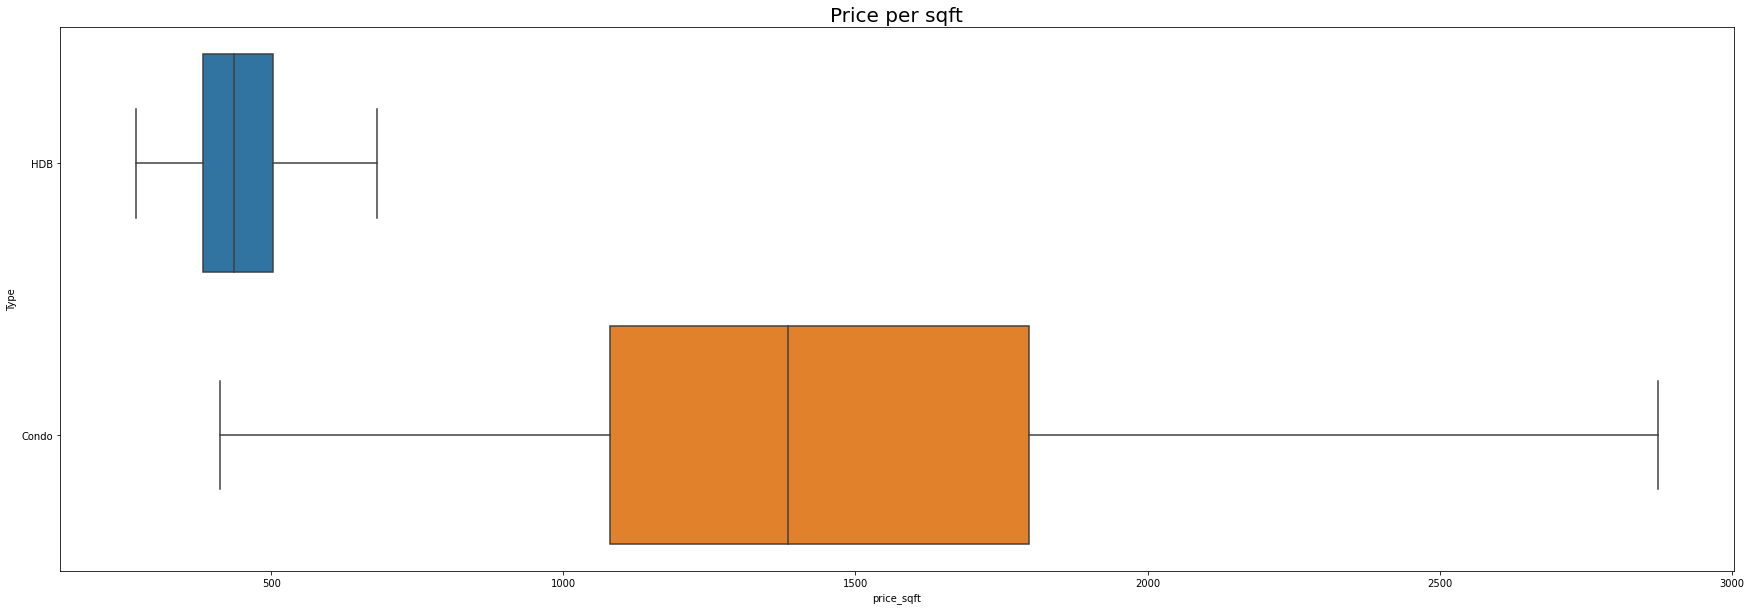

In [24]:
fig, ax = plt.subplots(1,1, figsize=(30,10))
sns.boxplot(y='Type', x='price_sqft', data= data, showfliers = False, ax=ax)
plt.title('Price per sqft', fontdict ={'fontsize': 20})

### Area

Text(0.5, 1.0, 'Area of Apartment')

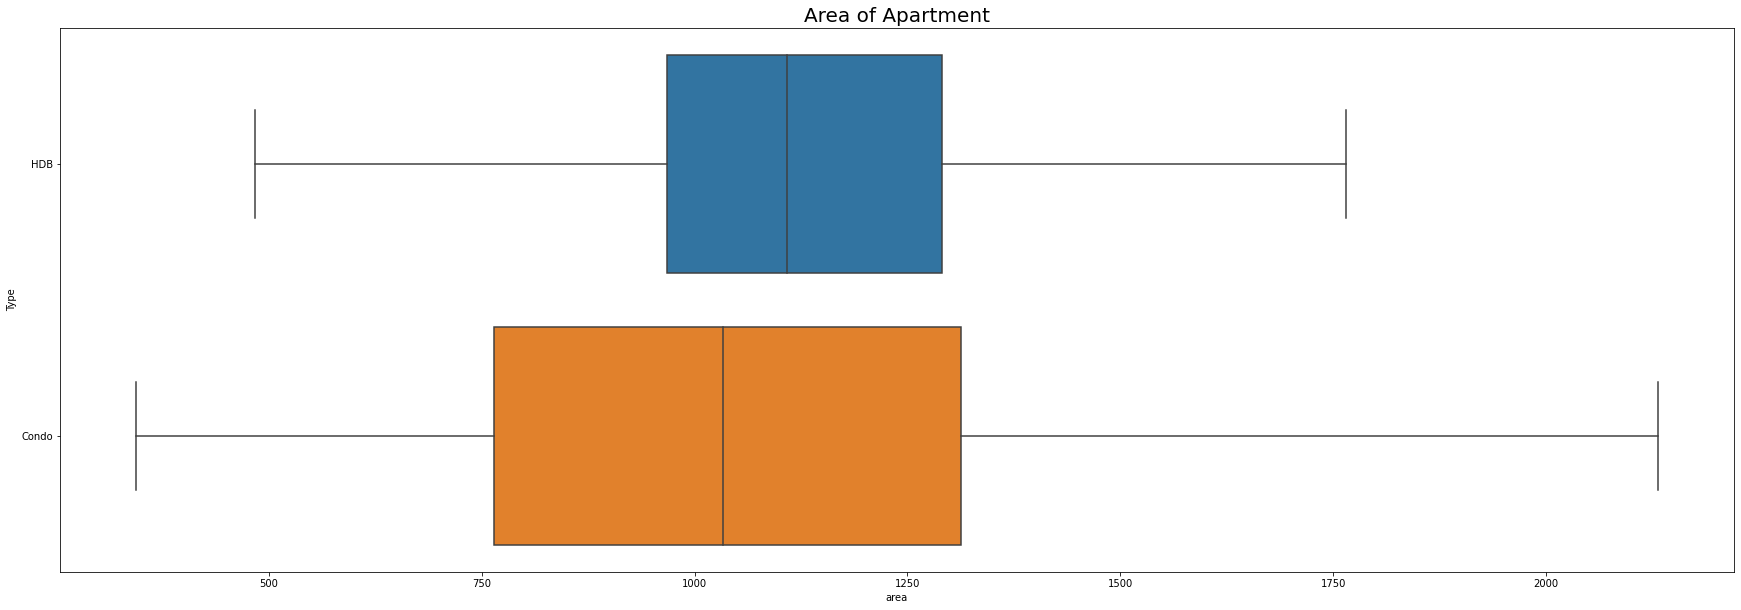

In [25]:
fig, ax = plt.subplots(1,1, figsize=(30,10))
sns.boxplot(y='Type', x='area', data=data, showfliers = False,ax=ax)
plt.title('Area of Apartment', fontdict ={'fontsize': 20})

HDB apartments are valued much lower than Condo apartments. However, it seems that the area of a typical HDB apartment is very similar to that of a typical condominium apartment.

Text(0.5, 1.0, 'Area of Bathroom in Apartment')

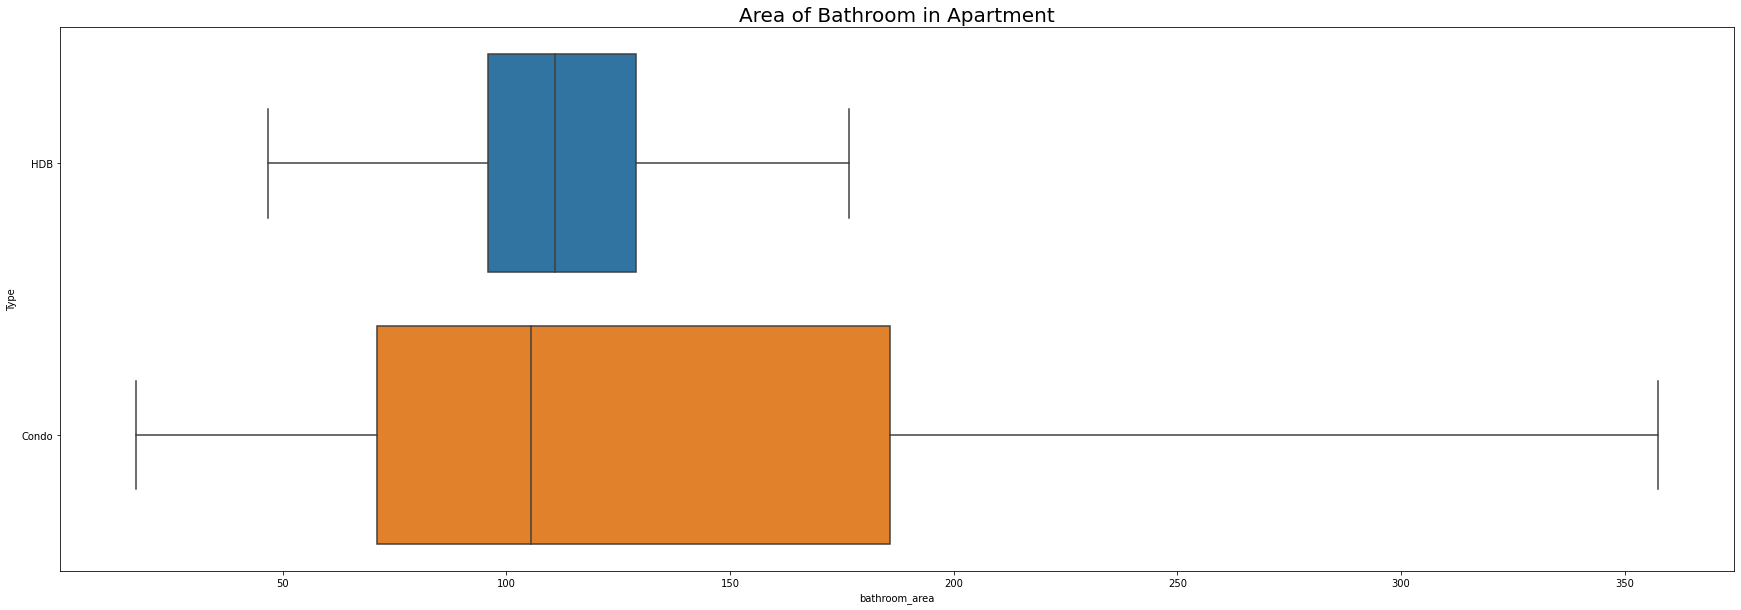

In [41]:
fig, ax = plt.subplots(1,1, figsize=(30,10))
sns.boxplot(y='Type', x='bathroom_area', data=data, showfliers = False,ax=ax)
plt.title('Area of Bathroom in Apartment', fontdict ={'fontsize': 20})

Text(0.5, 1.0, 'Area of Bedroom in Apartment')

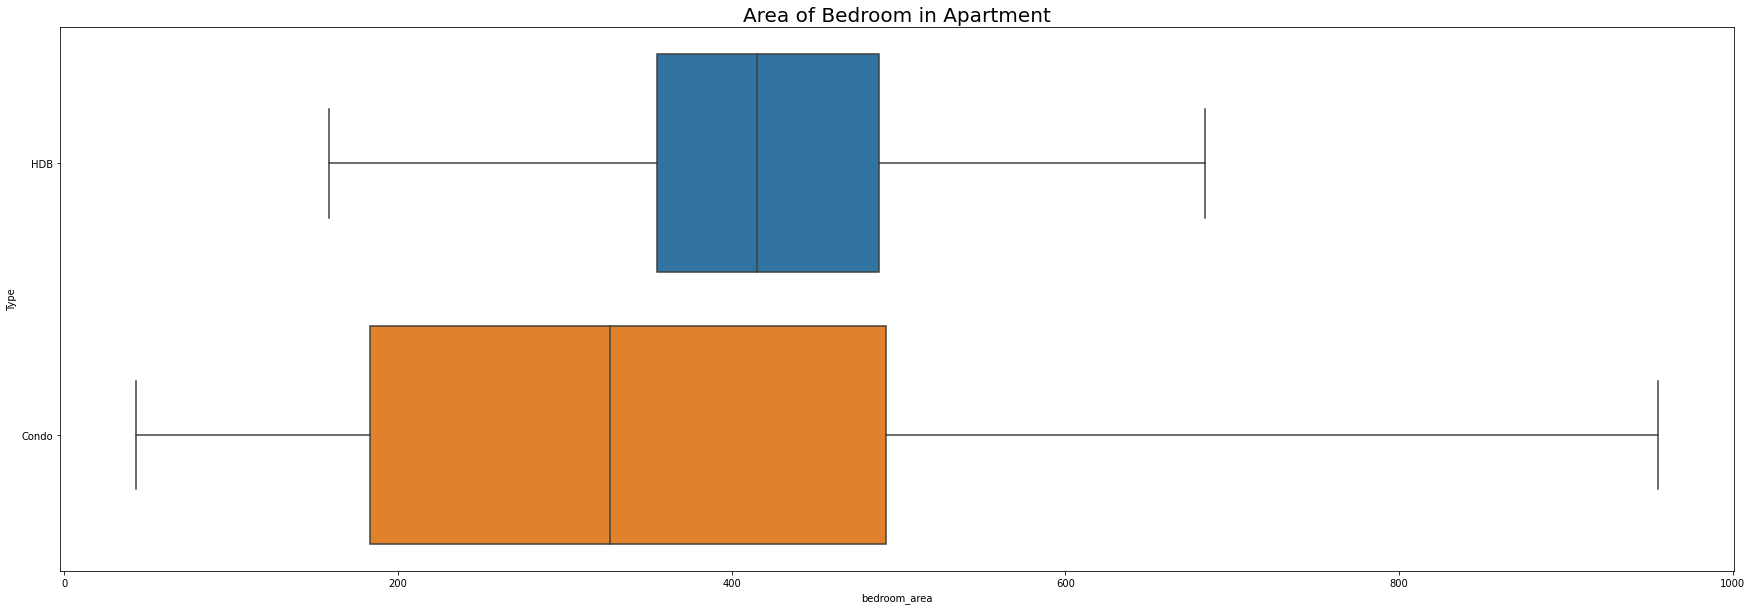

In [42]:
fig, ax = plt.subplots(1,1, figsize=(30,10))
sns.boxplot(y='Type', x='bedroom_area', data=data, showfliers = False,ax=ax)
plt.title('Area of Bedroom in Apartment', fontdict ={'fontsize': 20})

Text(0.5, 1.0, 'Living Area in Apartment')

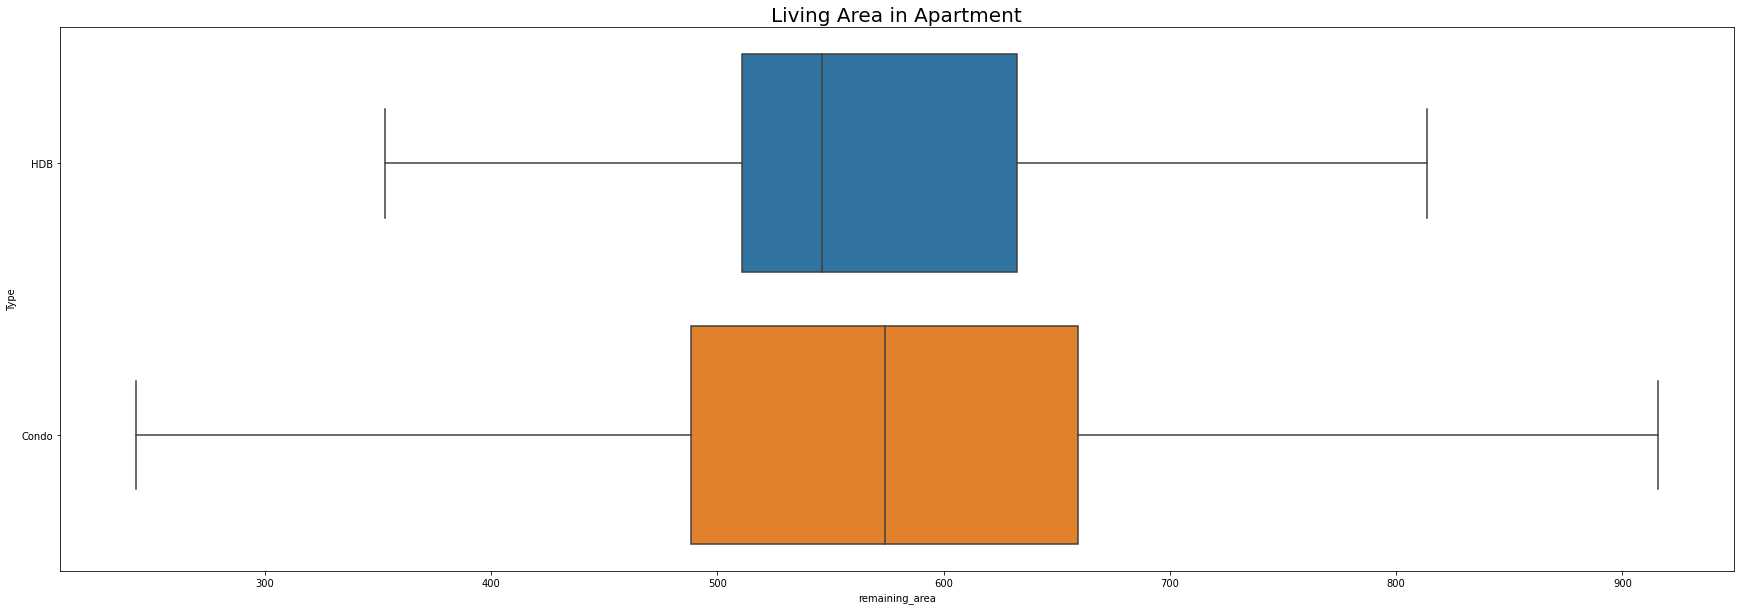

In [43]:
fig, ax = plt.subplots(1,1, figsize=(30,10))
sns.boxplot(y='Type', x='remaining_area', data=data, showfliers = False,ax=ax)
plt.title('Living Area in Apartment', fontdict ={'fontsize': 20})

### Latitude & Longitude

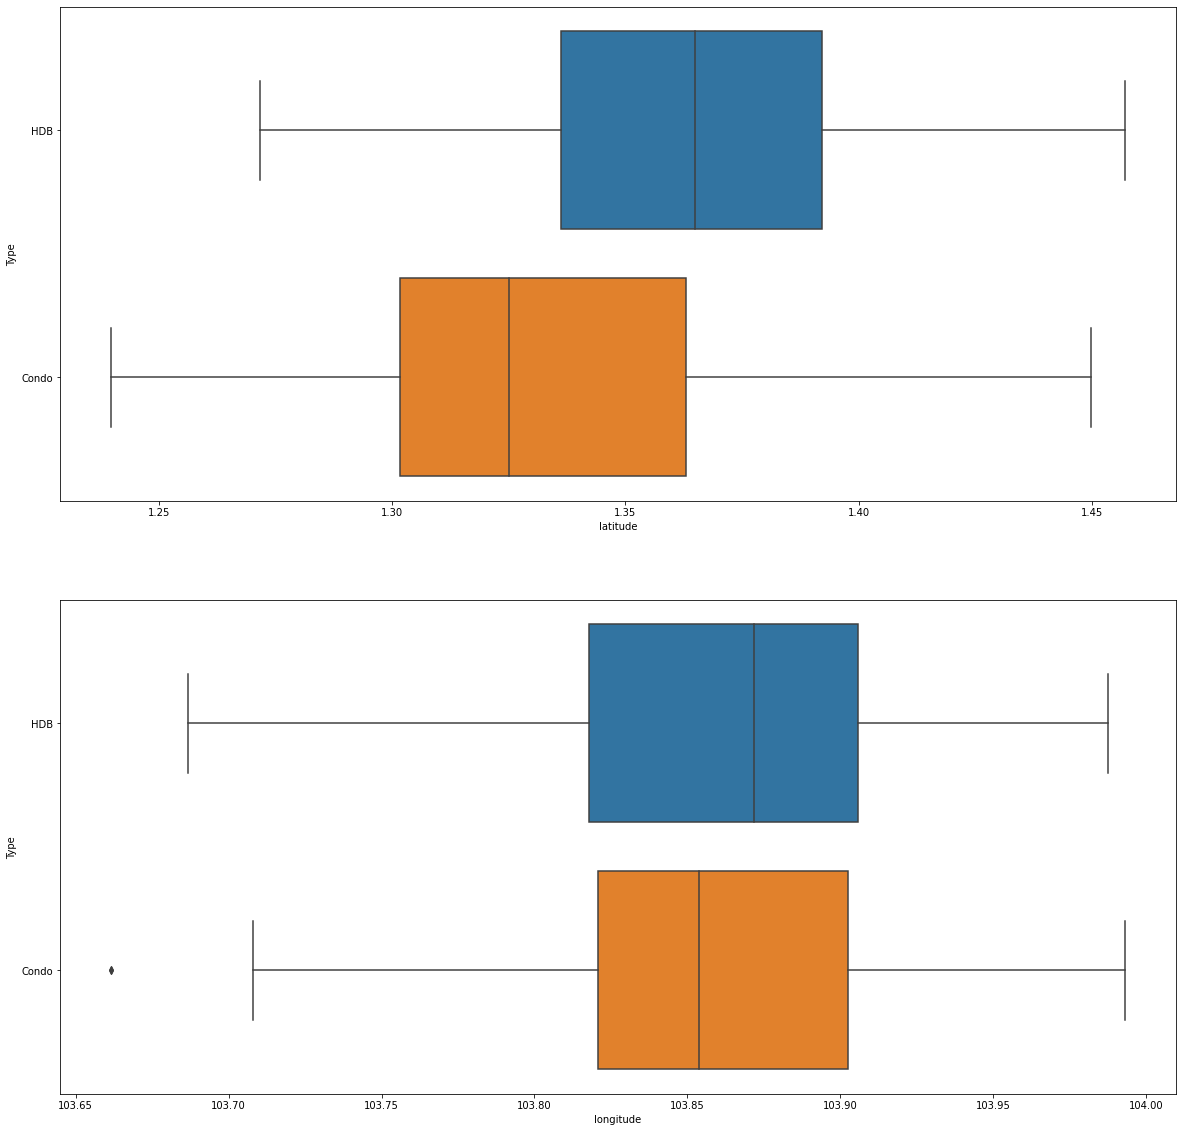

In [33]:
f, axes = plt.subplots(2,1, figsize=(20,20))
sns.boxplot(x='latitude', data=data, y='Type', ax=axes[0])
sns.boxplot(x='longitude', data=data, y='Type', ax=axes[1])

### Distance from Orchard (Central)

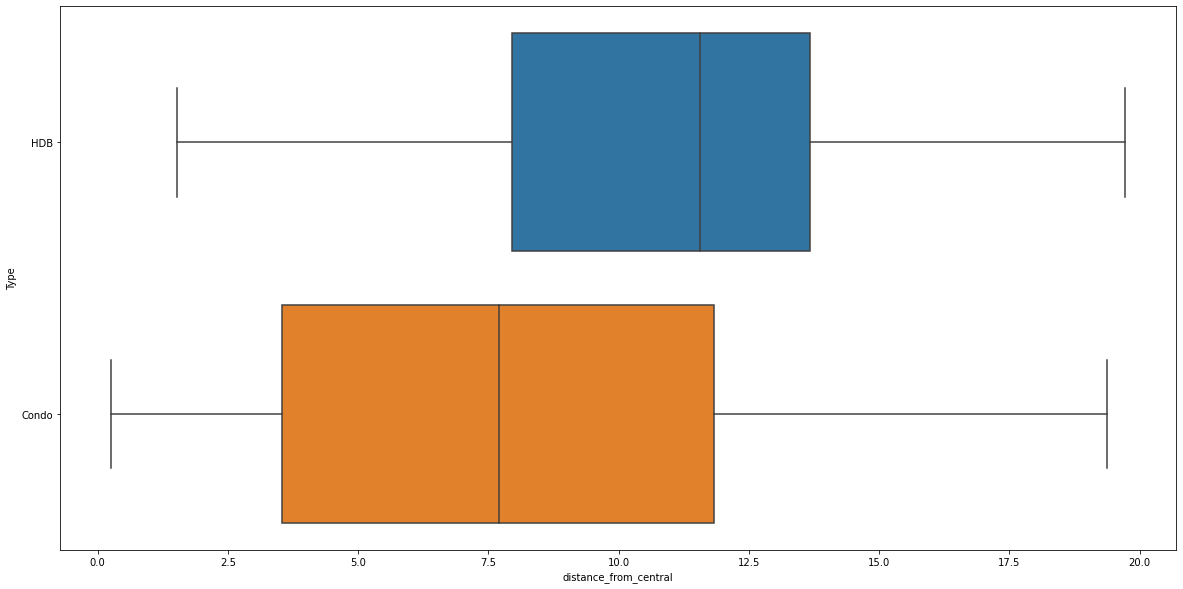

In [46]:
f, axes = plt.subplots(1,1, figsize=(20,10))
sns.boxplot(x='distance_from_central', data=data, y='Type', ax=axes)

The condominiums are nearer to the central area than HDBs.

### Age of Building

Text(0.5, 1.0, 'Distribution of Age, Condo')

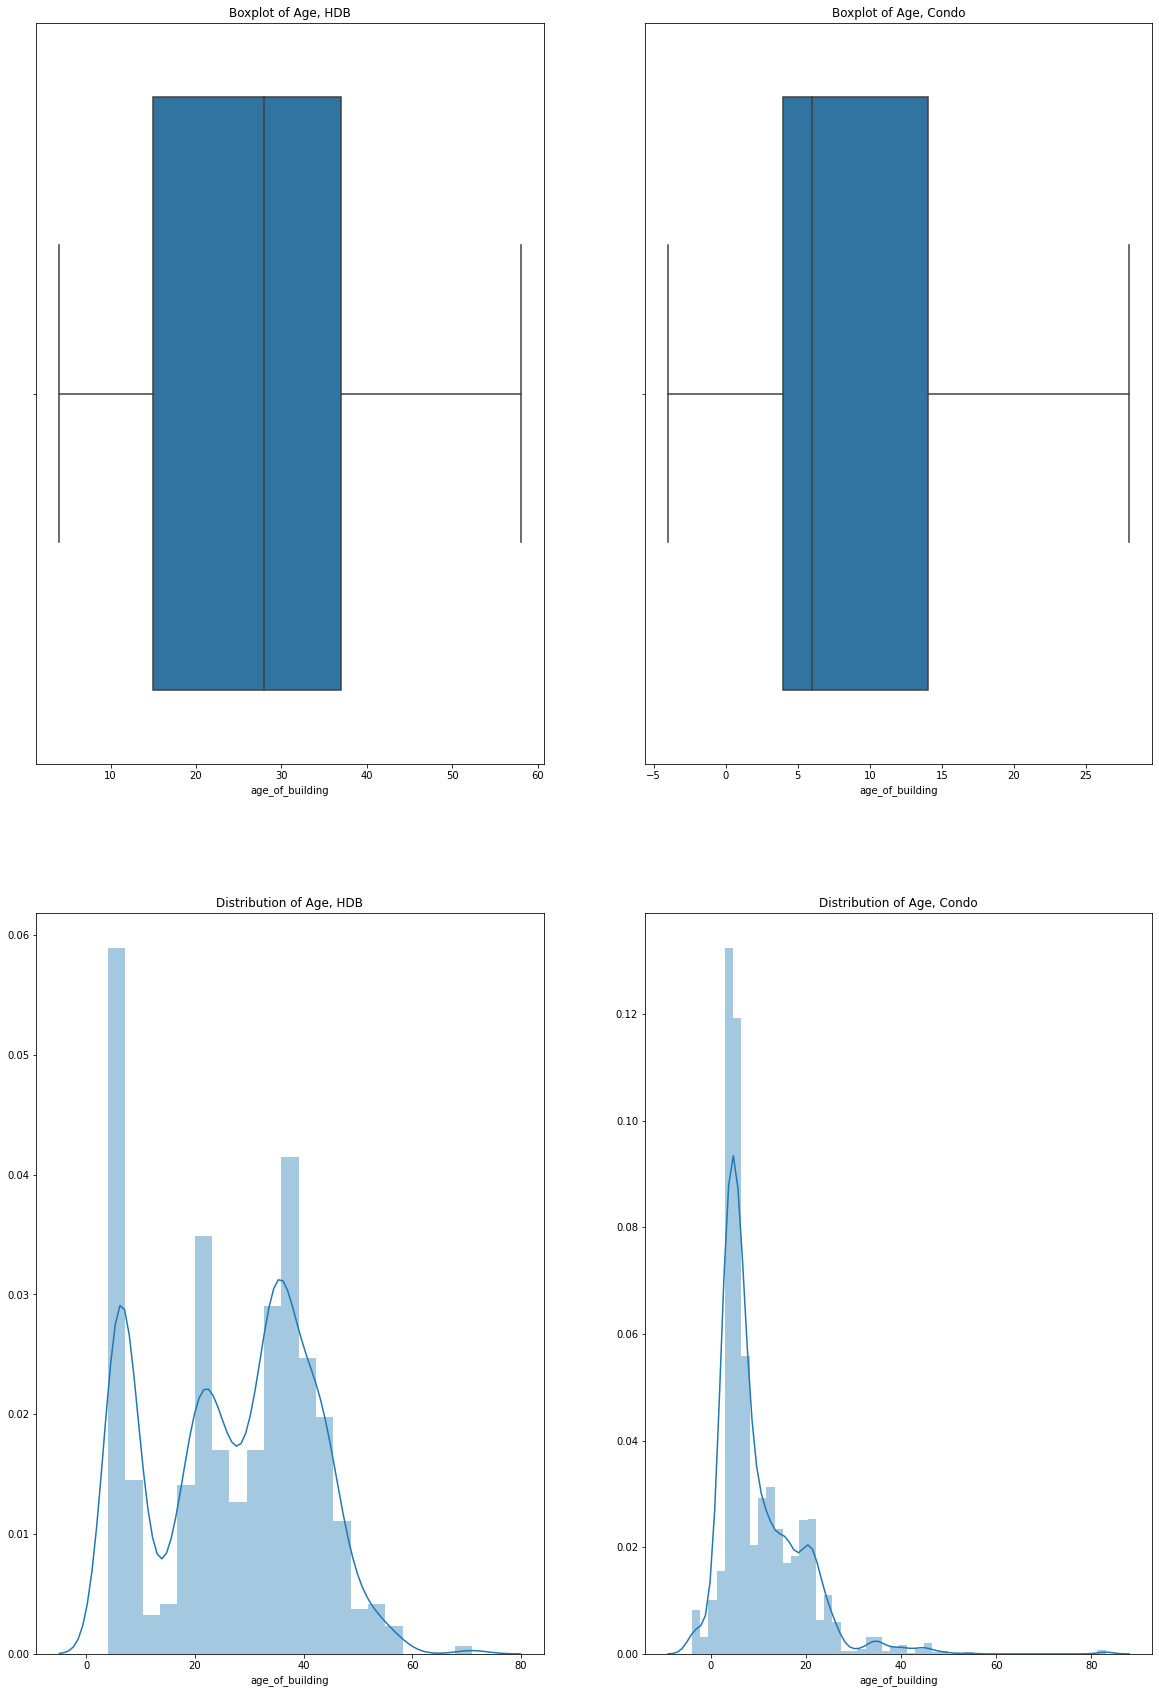

In [40]:
f,axes = plt.subplots(2,2, figsize=(20,30))

sns.boxplot(x='age_of_building', data=hdb, showfliers=False, ax=axes[0][0])
sns.boxplot(x='age_of_building', data=condo, showfliers=False, ax=axes[0][1])
sns.distplot(hdb['age_of_building'], ax=axes[1][0])
sns.distplot(condo['age_of_building'], ax=axes[1][1])

axes[0][0].set_title('Boxplot of Age, HDB')
axes[0][1].set_title('Boxplot of Age, Condo')
axes[1][0].set_title('Distribution of Age, HDB')
axes[1][1].set_title('Distribution of Age, Condo')

The condominium listings have relatively lower age than the HDB apartments.

### Discrete Features Analysis

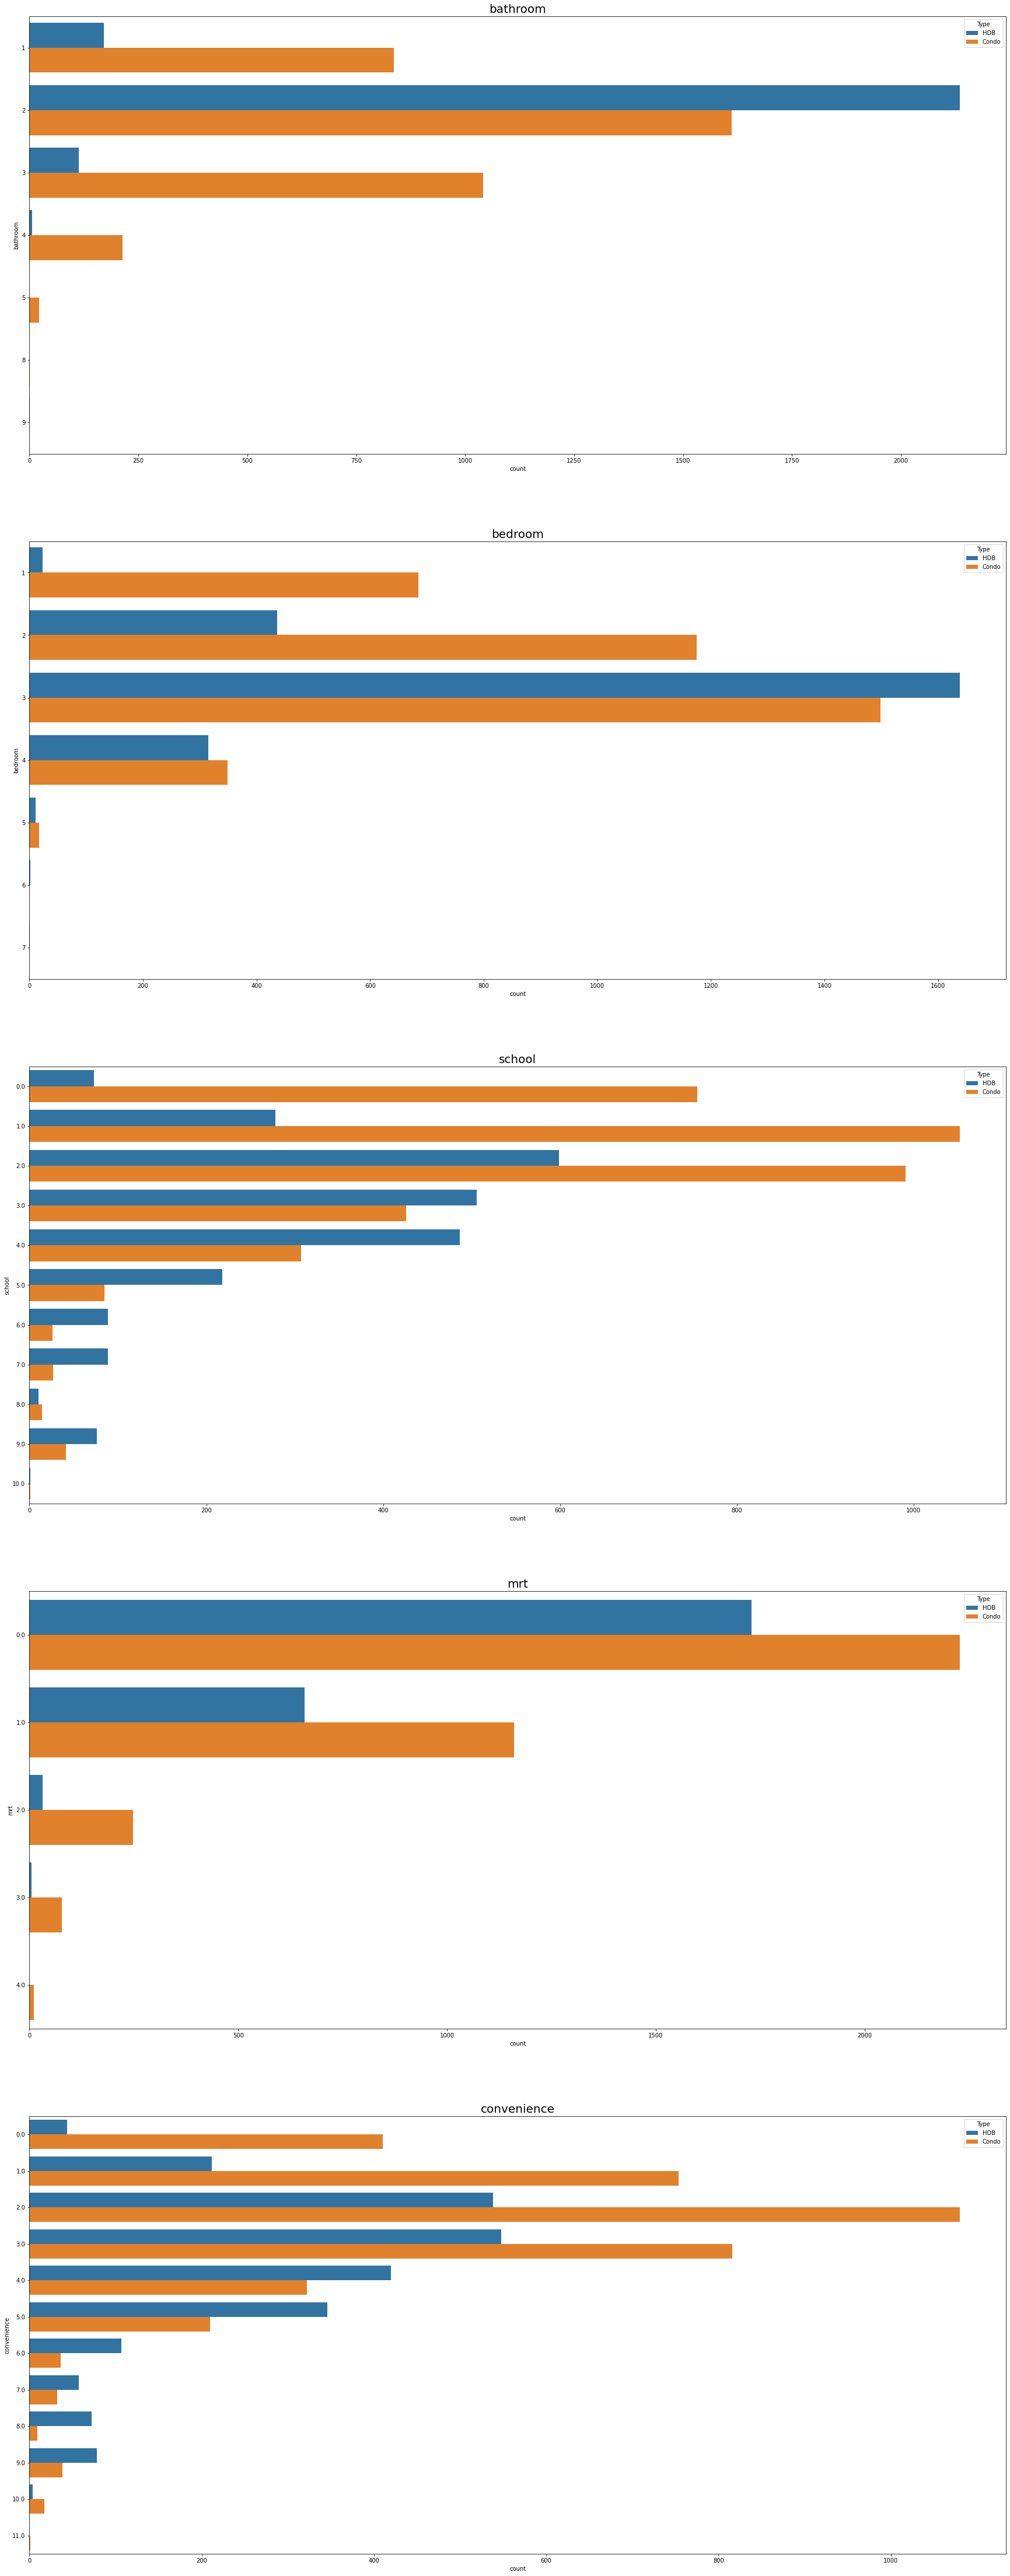

In [31]:
f,axes = plt.subplots(5,1,figsize=(30,80))
discrete = ['bathroom', 'bedroom', 'school', 'mrt', 'convenience']

for i in range(len(discrete)):
    sns.countplot(y=discrete[i], data=data, hue='Type', ax=axes[i])
    axes[i].set_title(discrete[i], fontdict ={'fontsize': 20})
    i += 1

<p>Almost all of the HDBs have two bathrooms, which is typical for 3-room apartments and above. However, the number of bathrooms seems to be normally distributed with mean of 2.</p>

<p>There seems to be similar number of HDB and condominium apartments with 3-5 bedrooms. However, for 2 bedrooms, there are significantly more condominiums. Therefore, the distribution of bedrooms for condo looks Normal, and that of HDB has a sharp peak at 3 bedrooms.</p>

<p>Most condos are built near to 0-2 primary schools. For HDBs, the number of primary schools seems to be almost normally distributed with mean at 2, though with a slight skew to the right.</p>

<p>Many of the apartments are not built near an MRT station. Therefore, the distributions are skewed to the right. Many more condominiums than HDB are built near 2-4 MRT stations. This might be due to the close proximity of condo to the central area, which contains more stations in an area.</p>

### 7.3 Bivariate Analysis <a name='bi'></a>
[Back to top](#Contents)<br>

### Listing Distribution in Singapore 
The geographical distribution of the house listings is shown below: 

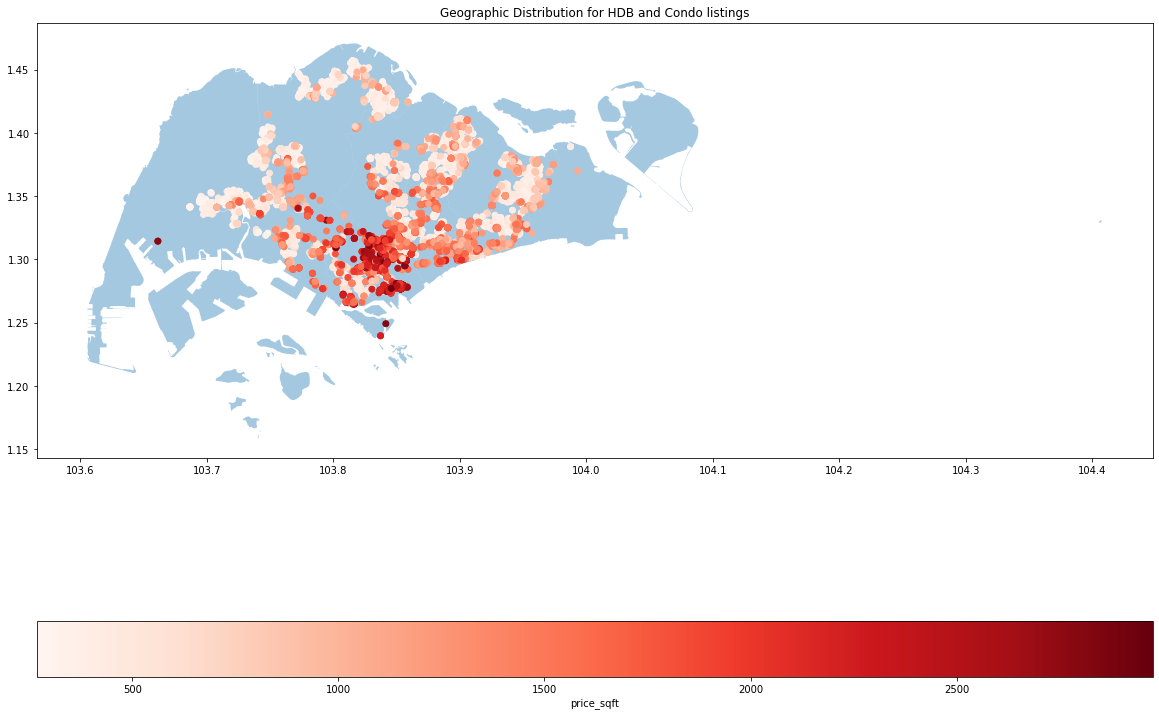

In [47]:
#Extract the coordinates for each listing 
house_geo = data[['price_sqft', 'Type','latitude', 'longitude']]

#Form new dataframe for geo_coordinates 
gdf = geopandas.GeoDataFrame(house_geo, geometry=geopandas.points_from_xy(house_geo.longitude, house_geo.latitude))

#Input the base map for Singapore
street_map = geopandas.read_file('igismap/poly.shp')

#plot the geographical distribution map 
fig,ax = plt.subplots(figsize=(20,20))
street_map.plot(ax=ax, alpha = 0.4, markersize=5) #plot the base map 
ax.set_title('Geographic Distribution for HDB and Condo listings')
gdf.plot(column='price_sqft', ax=ax,legend=True,legend_kwds={'label': "price_sqft",'orientation': "horizontal"},cmap='Reds') #plot the listing coordinates to the Singapore map

From the graph above, we observed that the housing price tend to increase when houses are located nearer to central/downtown region. The value of the house tends to be on the lower end when it is located outside the central region. 

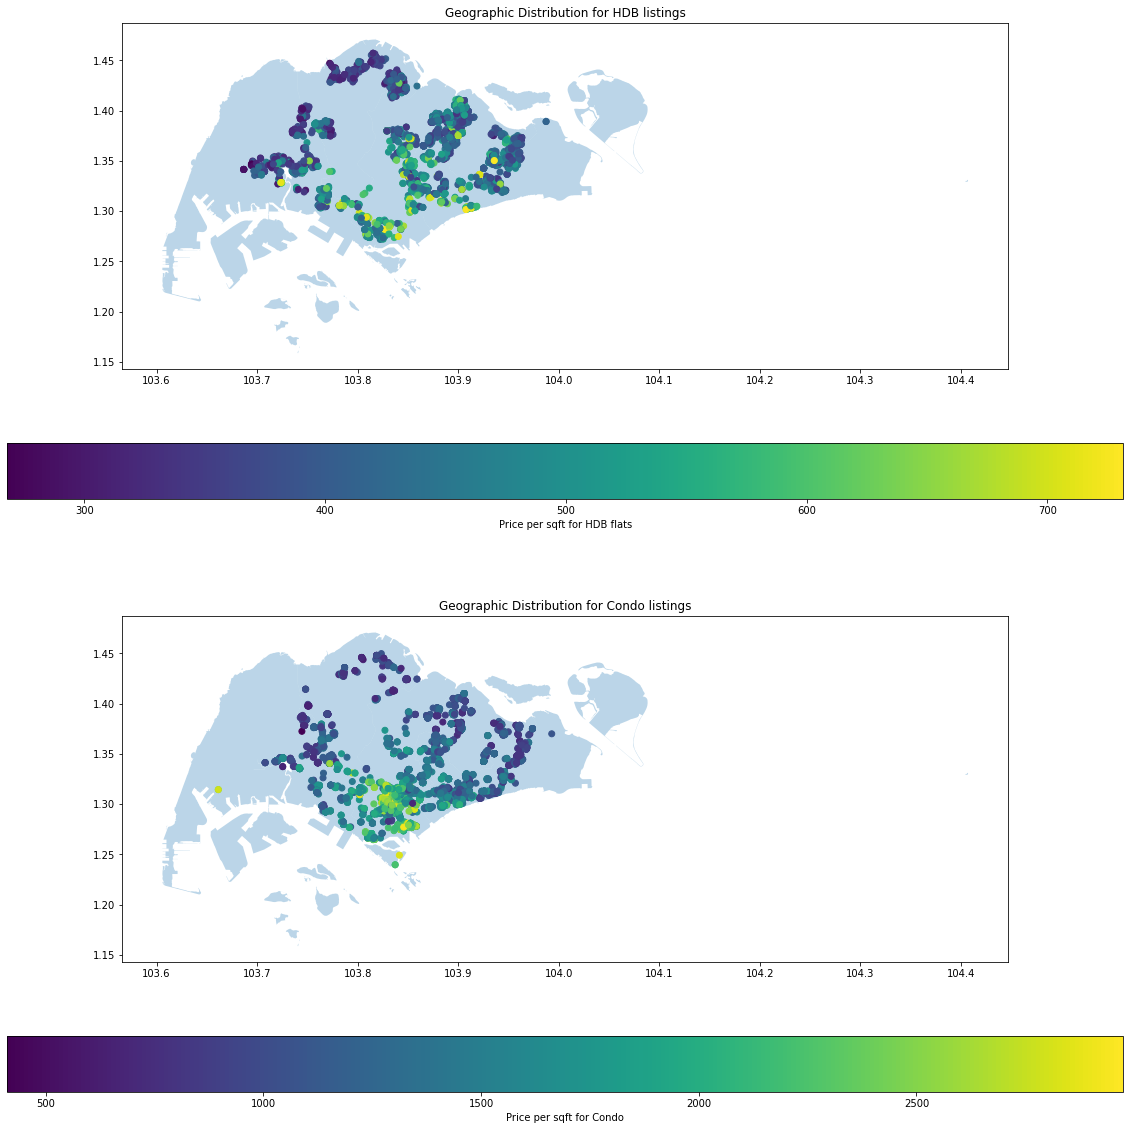

In [50]:
#plot the geographical map respective to their property 
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(20,20), sharey=True)
#plot HDB location 
street_map.plot(ax=ax1, alpha = 0.3)
ax1.set_title('Geographic Distribution for HDB listings')
gdf[gdf["Type"]=="HDB"].plot(column='price_sqft', ax=ax1, legend=True,legend_kwds={'label': "Price per sqft for HDB flats",'orientation': "horizontal"})

#plot Condo location 
street_map.plot(ax=ax2, alpha = 0.3)
ax2.set_title('Geographic Distribution for Condo listings')
gdf[gdf["Type"]=="Condo"].plot(column='price_sqft', ax=ax2, legend=True,legend_kwds={'label': "Price per sqft for Condo",'orientation': "horizontal"})


From the HDB geographic distribution, we observed that majority of the listings are outside of the central areas. For regions that are near central, the housing price tends to be at the upper-end of the scale.

To some extent, some condo listings are in central area and housing price are tend to be more expensive compared to other regions. 

## 4.6 Scatterplot Matrix and Correlation heatmap

The scatterplot matrix provides a overview on the relationship between each variables. By examing the scatterplot matrix, we can derive if there is any correlation between each predictor variables and response variable to understand the significant of each variable in the pricing model. 

In addition, we would be able to examine the correlation between each variables to understand if all predictor variables are independent from each other. 

In [53]:
sns.pairplot(data, hue= 'Type', kind="reg") #create the scatterplot matrix and seperate by the type of housing 
plt.subplots_adjust(top=0.93)
plt.suptitle('Pair Plot of housing data', size = 17);

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000011F5D3B6158> (for post_execute):


KeyboardInterrupt: 

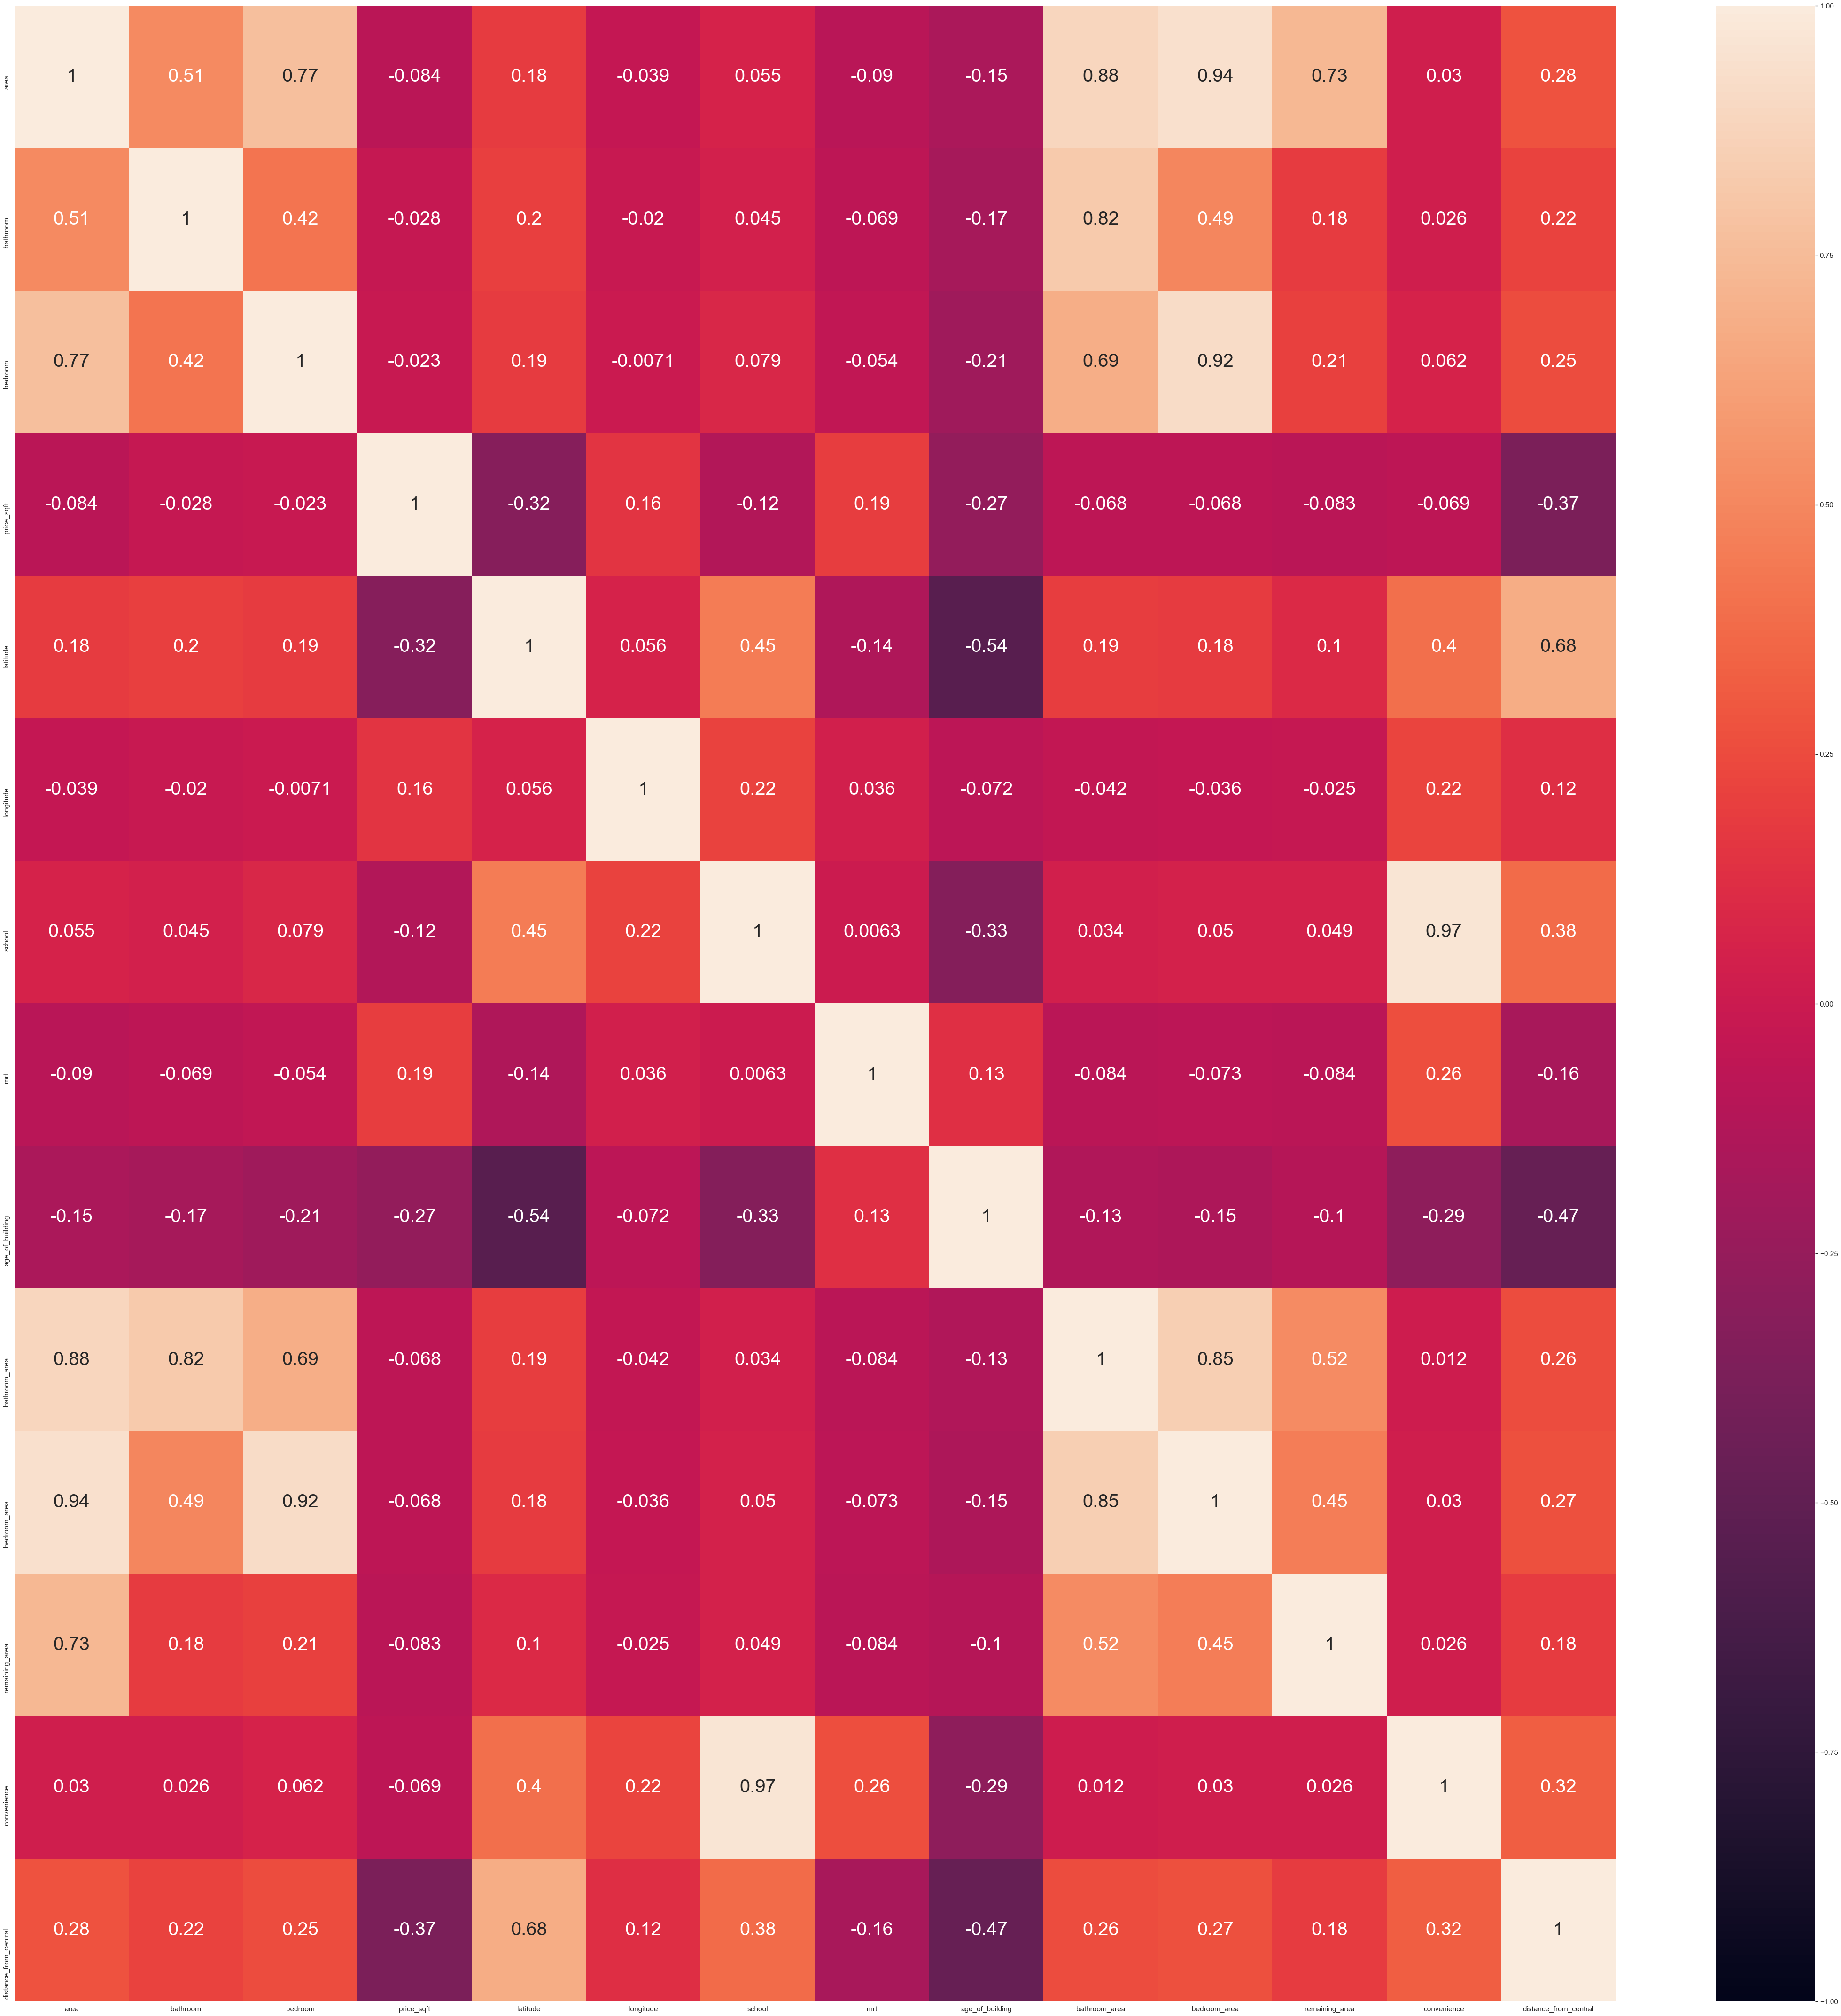

In [66]:
f, axes = plt.subplots(1,1,figsize=(60,60))
sns.set(font_scale=1.4)
sns.heatmap(hdb.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"size": 40})
plt.tight_layout()

In [67]:
hdb.corr()

,area,bathroom,bedroom,price_sqft,latitude,longitude,school,mrt,age_of_building,bathroom_area,bedroom_area,remaining_area,convenience,distance_from_central
area,1.000000,0.512833,0.773252,-0.084130,0.183991,-0.038509,0.054886,-0.089645,-0.150373,0.884708,0.937668,0.727448,0.030248,0.279376
bathroom,0.512833,1.000000,0.420339,-0.027698,0.198767,-0.019503,0.044633,-0.069067,-0.172381,0.823501,0.493630,0.183241,0.025570,0.217409
bedroom,0.773252,0.420339,1.000000,-0.023325,0.186621,-0.007131,0.078723,-0.053605,-0.206181,0.685126,0.920629,0.205541,0.062413,0.251245
price_sqft,-0.084130,-0.027698,-0.023325,1.000000,-0.322707,0.155194,-0.121622,0.192716,-0.265479,-0.068162,-0.068362,-0.083207,-0.068531,-0.370823
latitude,0.183991,0.198767,0.186621,-0.322707,1.000000,0.056366,0.447460,-0.138080,-0.543490,0.192817,0.183569,0.100180,0.397044,0.678819
longitude,-0.038509,-0.019503,-0.007131,0.155194,0.056366,1.000000,0.217582,0.035649,-0.072206,-0.042051,-0.035853,-0.024885,0.219156,0.120985
school,0.054886,0.044633,0.078723,-0.121622,0.447460,0.217582,1.000000,0.006325,-0.328693,0.034010,0.049884,0.049359,0.967255,0.376046
mrt,-0.089645,-0.069067,-0.053605,0.192716,-0.138080,0.035649,0.006325,1.000000,0.127554,-0.083817,-0.072812,-0.083681,0.259918,-0.164894
age_of_building,-0.150373,-0.172381,-0.206181,-0.265479,-0.543490,-0.072206,-0.328693,0.127554,1.000000,-0.130977,-0.145787,-0.101590,-0.285028,-0.472894
bathroom_area,0.884708,0.823501,0.685126,-0.068162,0.192817,-0.042051,0.034010,-0.083817,-0.130977,1.000000,0.845049,0.517480,0.011568,0.255227


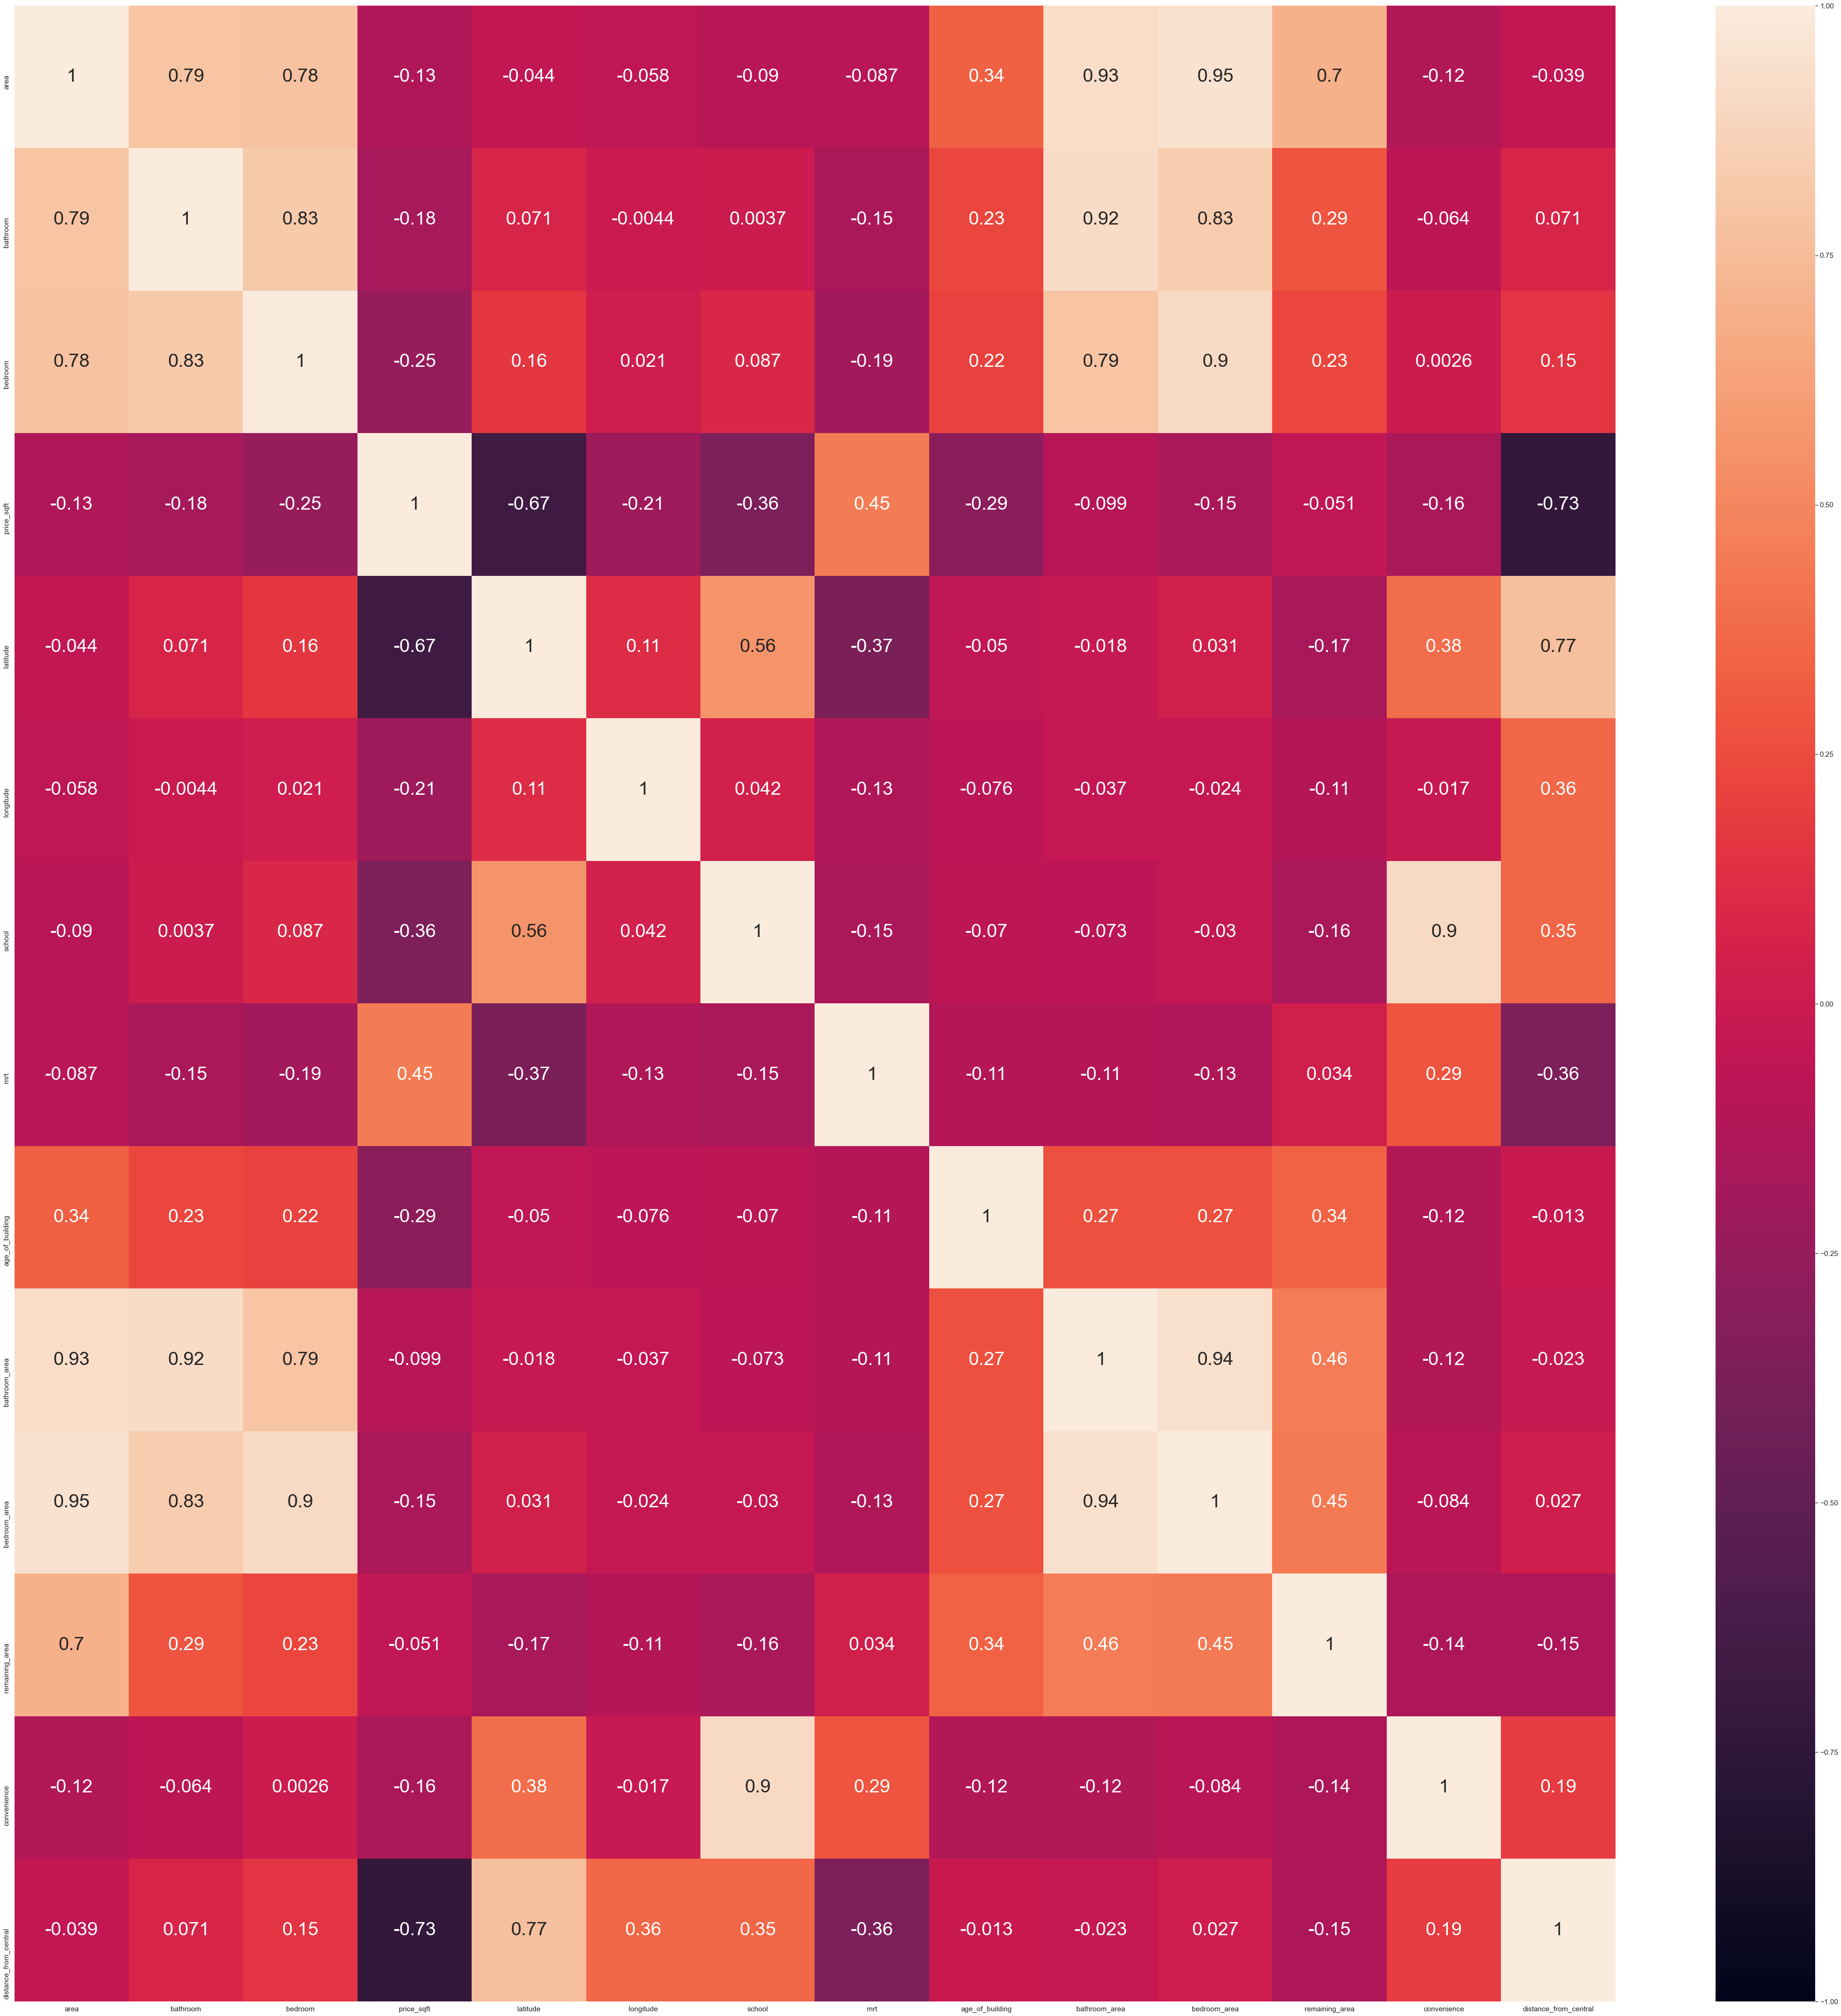

In [68]:
f, axes = plt.subplots(1,1,figsize=(60,60))
sns.set(font_scale=1.4)
sns.heatmap(condo.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"size": 40})
plt.tight_layout()

In [69]:
condo.corr()

,area,bathroom,bedroom,price_sqft,latitude,longitude,school,mrt,age_of_building,bathroom_area,bedroom_area,remaining_area,convenience,distance_from_central
area,1.000000,0.789976,0.784315,-0.126401,-0.043932,-0.058409,-0.089563,-0.087261,0.335353,0.928026,0.946315,0.702237,-0.124894,-0.039110
bathroom,0.789976,1.000000,0.826121,-0.178828,0.071209,-0.004410,0.003654,-0.154515,0.233313,0.916451,0.831464,0.288808,-0.063765,0.071186
bedroom,0.784315,0.826121,1.000000,-0.247266,0.157058,0.021113,0.086569,-0.186840,0.215168,0.793954,0.901841,0.233252,0.002585,0.153468
price_sqft,-0.126401,-0.178828,-0.247266,1.000000,-0.668758,-0.211883,-0.364594,0.447379,-0.294407,-0.098560,-0.148833,-0.051205,-0.158789,-0.731959
latitude,-0.043932,0.071209,0.157058,-0.668758,1.000000,0.114746,0.559849,-0.367225,-0.049545,-0.017915,0.031381,-0.171065,0.383114,0.767314
longitude,-0.058409,-0.004410,0.021113,-0.211883,0.114746,1.000000,0.042443,-0.133148,-0.076207,-0.037220,-0.024069,-0.105795,-0.016829,0.364363
school,-0.089563,0.003654,0.086569,-0.364594,0.559849,0.042443,1.000000,-0.154732,-0.070292,-0.073214,-0.029795,-0.163648,0.902651,0.354130
mrt,-0.087261,-0.154515,-0.186840,0.447379,-0.367225,-0.133148,-0.154732,1.000000,-0.114542,-0.109800,-0.126893,0.033854,0.285522,-0.360250
age_of_building,0.335353,0.233313,0.215168,-0.294407,-0.049545,-0.076207,-0.070292,-0.114542,1.000000,0.267667,0.271396,0.343252,-0.118085,-0.012677
bathroom_area,0.928026,0.916451,0.793954,-0.098560,-0.017915,-0.037220,-0.073214,-0.109800,0.267667,1.000000,0.938866,0.455267,-0.118853,-0.022762


Based on the scatterplot matrix, there does not seems to have a strong linear relationship between the predictor variables and the price variable. However, there seems to have some positive correlation between price and predictor variables like "Land_area", "no of bedrm", "no of bathrm", "Price_per_sqft", and "no of mrt". On the other hand, there seems to have some negative correlation between price and predictor variables like "age_of_building" and "no of school". 

In general, there seems to have some correlation between the predictor variables which might suggest multicollinearity in the data. 

Lastly, based on the histogram plot, most of the variables seems to be normally distributed but some has skewed distribution, like number of mrt station and number of bathrm. 

**Analysis**

Based on the data correlation matrix, "Price_per_sqft", "Land_Area", "Built" and "No_of_bathrm" seems to have positively medium to high correlation, while "number of school" and "age of building" seems to have negatively correlation to the "Price" variable. In general, there are some strong correlation among Land area, no of bathroom and bedroom. This could pose a problem in linear regression model as the correlation between predictor variables leads to multicollinearity.

Based on the HDB correlation matrix, "Price_per_sqft", "Land_Area" and "No_of_bedrm" seems to have positively high correlation, compared to the "Price" variable. There is some strong correlation among Land area and no of bedroom. Variables like "no of school", "no of mrt" and "age of building" seems to have a low correlation to other predictor variables, this might suggest that these variables might be independent variable. 

Based on the Condo correlation matrix, "Price_per_sqft", "Land_Area", "Built", "No of bedrm" and "No_of_bathrm" seems to have positively medium to high correlation to the "Price" variable. There is some strong correlation among Land area, no of bathrm and no of bedroom. This aligns with our conclusion in data correlation matrix.  

## 8. Data Preprocessing <a name='data-preprocess'></a>
[Back to top](#Contents)<br>

In [116]:
data = pd.read_csv('data/data_eng.csv')

First, we one-hot encode the categorical variables.

In [117]:
data = pd.get_dummies(data, prefix='type', columns=['Type'])
data = data[[c for c in data if c not in ['price_sqft', 'type_Condo', 'type_HDB']] + ['type_HDB', 'type_Condo','price_sqft']]

Next, we stratified-split the dataset into training and test sets.

In [118]:
hdb = data[data['type_HDB'] == 1]
condo = data[data['type_Condo'] == 1]

train_hdb, test_hdb = train_test_split(hdb, test_size=0.1)
train_condo, test_condo = train_test_split(condo, test_size=0.1)

train = pd.concat([train_hdb, train_condo], axis=0).reset_index(drop=True)
test = pd.concat([test_hdb, test_condo], axis=0).reset_index(drop=True)

After that, we scaled the features of the training data by z-scoring. We are careful not to introduce any data leakage by using the same scaler to scale the test data.

In [119]:
scaler = StandardScaler()
train.iloc[:,:-3] = scaler.fit_transform(train.iloc[:,:-3]) #Excludes type_hdb, type_condo, price_sqft
test.iloc[:,:-3] = scaler.transform(test.iloc[:,:-3])

Finally, we store the training and test data into their respective files, and also the scaler used to scale the training data. This scaler can be used to scale any future test data we used.

In [120]:
train.to_csv('data/train.csv', index=False)
test.to_csv('data/test.csv', index=False)
pickle.dump(scaler, open('model/object/scaler.pickle', 'wb'))

## 9. Data Analysis <a name='data-analysis'></a>
[Back to top](#Contents)<br>

Since we are predicting the price per square feet, this is a Regression problem. Hence, we will use regression models, more specifically those from scikit-learn.

First of all, we define our scoring function, Root Mean Square Error (RMSE).

In [91]:
def rmse(pred, actual):
    return np.sqrt(mean_squared_error(pred, actual))

Next, we import our training data, and define our KFold for preliminary model testing.

In [123]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [137]:
kfold = KFold(n_splits=5)

### 9.1. Linear Regression <a name='linreg'></a>
[Back to top](#Contents)<br>

#### Simple Linear Regression

In [19]:
err = []

for train_idx, test_idx in kfold.split(train):
    train_x = train.iloc[train_idx, :-1]
    train_y = train.iloc[train_idx, -1]
    test_x = train.iloc[test_idx, :-1]
    test_y = train.iloc[test_idx, -1]
    
    linreg = LinearRegression()
    linreg.fit(train_x, train_y)
    y_pred = linreg.predict(test_x)
    err.append(rmse(y_pred, test_y))

print("RMSE: ", err)
print("Average RMSE: ", np.mean(err))

RMSE:  [183.51993345808003, 190.8911706815273, 294.9018827362626, 303.3079108752656, 306.1510613309703]
Average RMSE:  255.7543918164212


#### Now, we try higher degrees to improve our accuracy

In [20]:
deg = [2,3,4,5,6]

for d in deg:
    
    err = []

    for train_idx, test_idx in kfold.split(train):
        
        poly = PolynomialFeatures(degree=d)
        
        train_x = train.iloc[train_idx, :-1]
        train_y = train.iloc[train_idx, -1]
        test_x = train.iloc[test_idx, :-1]
        test_y = train.iloc[test_idx, -1]
        
        train_x = poly.fit_transform(train_x)
        test_x = poly.transform(test_x)

        linreg = LinearRegression()
        linreg.fit(train_x, train_y)
        y_pred = linreg.predict(test_x)
        err.append(rmse(y_pred, test_y))

    print("RMSE for degree ", d, ": ", err)
    print("Average RMSE for degree ", d, ": ", np.mean(err))
    print()

RMSE for degree  2 :  [88.41748455524154, 89.21247619975938, 251.24691769466733, 266.33273255144263, 268.1805491121271]
Average RMSE for degree  2 :  192.6780320226476

RMSE for degree  3 :  [103.28033356035864, 101.12303204721815, 241.87885584201877, 257.99370919548073, 267.2928094051513]
Average RMSE for degree  3 :  194.31374801004552

RMSE for degree  4 :  [4906.892975863304, 192.4328681635377, 299.20256565444356, 2948.953166201464, 330.4197492023406]
Average RMSE for degree  4 :  1735.5802650170183

RMSE for degree  5 :  [1531.5930070275613, 759.5850068539391, 475.9962488494986, 6459.83894257086, 643.4994768632502]
Average RMSE for degree  5 :  1974.1025364330217

RMSE for degree  6 :  [8708.351399615136, 531.4982330515871, 524.6226320234839, 2429.6345017642293, 1652.9240092441362]
Average RMSE for degree  6 :  2769.4061551397144



<p>The RMSE for lower degrees is decent. However, it exploded from 4 onwards due to high variance.</p>
<p>To prevent overfitting while lowering bias, we can include a regularisation parameter. This can be achieved with the Ridge Regresssion.</p>

### 9.2. Ridge Regression <a name='ridge'></a>
[Back to top](#Contents)<br>

#### Ridge Regression with GridSearch

In [12]:
deg = [2,3,4,5]
logalpha = np.arange(-3, 4, 1.0)
alpha = 10.0 ** logalpha

m = len(alpha)
n = len(deg)
grid_err = np.array([0] * (m*n)).reshape(m, n)
i = j = 0

for a in alpha:
    j=0
    for d in deg:
    
        err = []
        poly = PolynomialFeatures(degree=d)
        X = poly.fit_transform(train.iloc[:,:-1])

        for train_idx, test_idx in kfold.split(X):

            train_x = X[train_idx]
            train_y = train.iloc[train_idx, -1]
            test_x = X[test_idx]
            test_y = train.iloc[test_idx, -1]

            linreg = Ridge(alpha=a)
            linreg.fit(train_x, train_y)
            y_pred = linreg.predict(test_x)
            err.append(rmse(y_pred, test_y))
            
        grid_err[i, j] = np.mean(err)
        print("RMSE for degree {}, alpha {}: {}".format(d, a, err))
        print("Average RMSE for degree {}, alpha {}: {}".format(d, a, np.mean(err)))
        print()
        j += 1
        
    i += 1

RMSE for degree 2, alpha 0.001: [117.51086177017918, 85.3749667330402, 223.4577987928067, 281.9767657021247, 236.83143214207678]
Average RMSE for degree 2, alpha 0.001: 189.0303650280455

RMSE for degree 3, alpha 0.001: [288.7237866064351, 95.43917540462675, 210.72844534424766, 786.603823811369, 225.7566316968845]
Average RMSE for degree 3, alpha 0.001: 321.4503725727126

RMSE for degree 4, alpha 0.001: [78212.02853878315, 869.5221092148257, 3456.625311208309, 12249.999134539996, 4872.002513735793]
Average RMSE for degree 4, alpha 0.001: 19932.035521496415

RMSE for degree 5, alpha 0.001: [254326.09481663664, 29616.00876609183, 20394.348306110507, 17900.74215331261, 59239.016289980835]
Average RMSE for degree 5, alpha 0.001: 76295.2420664265

RMSE for degree 2, alpha 0.01: [117.32332137000499, 85.36482375499963, 223.45309907635817, 280.51507306086745, 236.83283221092054]
Average RMSE for degree 2, alpha 0.01: 188.69782989463016

RMSE for degree 3, alpha 0.01: [236.60983234963524, 94.17

In [13]:
min_index = np.unravel_index(grid_err.argmin(), grid_err.shape)
print(min_index)
print("Best alpha: ", alpha[min_index[0]])
print("Best degree: ", deg[min_index[1]])
print("Min error: ", grid_err[min_index])

(5, 1)
Best alpha:  100.0
Best degree:  3
Min error:  170


<p>The best hyperparameters for Ridge Regression are alpha=100 and degree=3.</p>

#### Accuracy of Ridge Regression on Test set

In [124]:
ridge = Ridge(alpha=100).fit(PolynomialFeatures(degree=3).fit_transform(train.iloc[:,:-1]), train.iloc[:,-1])
test = pd.read_csv('data/test.csv')
print("RMSE for Ridge: ", rmse(ridge.predict(PolynomialFeatures(degree=3).fit_transform(test.iloc[:,:-1])), test.iloc[:,-1]))

RMSE for Ridge:  164.97732253734705


<p>By using polynomial terms and a regularisation parameter to reduce overfitting, the RMSE is reduced from 255.754 to 170. However, this still means that for an apartment of 1000 sqft, the error in price is as large as 170,000. Hence, we need to seek for models with much lower bias, while at the same time keeping variance low.</p>

### 9.3. RandomForestRegressor <a name='rf'></a>
[Back to top](#Contents)<br>

#### Simple RandomForestRegressor

In [11]:
err = []

for train_idx, test_idx in kfold.split(X):
    train_x = train.iloc[train_idx, :-1]
    test_x = train.iloc[test_idx, :-1]

    train_y = train.iloc[train_idx, -1]
    test_y = train.iloc[test_idx, -1]

    rf = RandomForestRegressor()
    rf.fit(train_x, train_y)
    y_pred = rf.predict(test_x)
    err.append(rmse(y_pred, test_y))

print(err)
print(np.mean(err))

[50.25665772318554, 45.93426504151863, 164.38064286133024, 166.9951077939572, 171.2719597046858]
119.76772662493549


#### Hyperparameter selection for RFRegressor

In [6]:
param = {
    'n_estimators': np.arange(50, 550, 100), # Number of forests
    'max_depth': [3,6,9,12,15], # Maximum depth of each tree
    'max_features': [0.5, 0.7, 0.9], # Maximum number of features to consider at each split
    'min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid=param, cv=5)
grid_search.fit(train.iloc[:,:-1], train.iloc[:,-1])
best_param = grid_search.best_params_

print(best_param)

{'max_depth': 15, 'max_features': 0.7, 'min_samples_split': 2, 'n_estimators': 250}


In [125]:
rf = RandomForestRegressor(max_depth=15, max_features=0.7, min_samples_split=2, n_estimators=250)
rf.fit(train.iloc[:,:-1], train.iloc[:,-1])
f_importance = pd.DataFrame(columns=['Features', 'Importance'])
f_importance['Features'] = train.columns[:-1]
f_importance['Importance'] = rf.feature_importances_
f_importance.sort_values(by='Importance', inplace=True, ascending=False)
f_importance

,Features,Importance
14,type_hdb,0.322583
13,type_condo,0.280117
12,distance_from_central,0.159807
3,lat,0.100556
7,age,0.053819
4,long,0.027511
0,area,0.012457
10,remaining_area,0.011491
6,mrt,0.009197
8,bathroom_area,0.007294


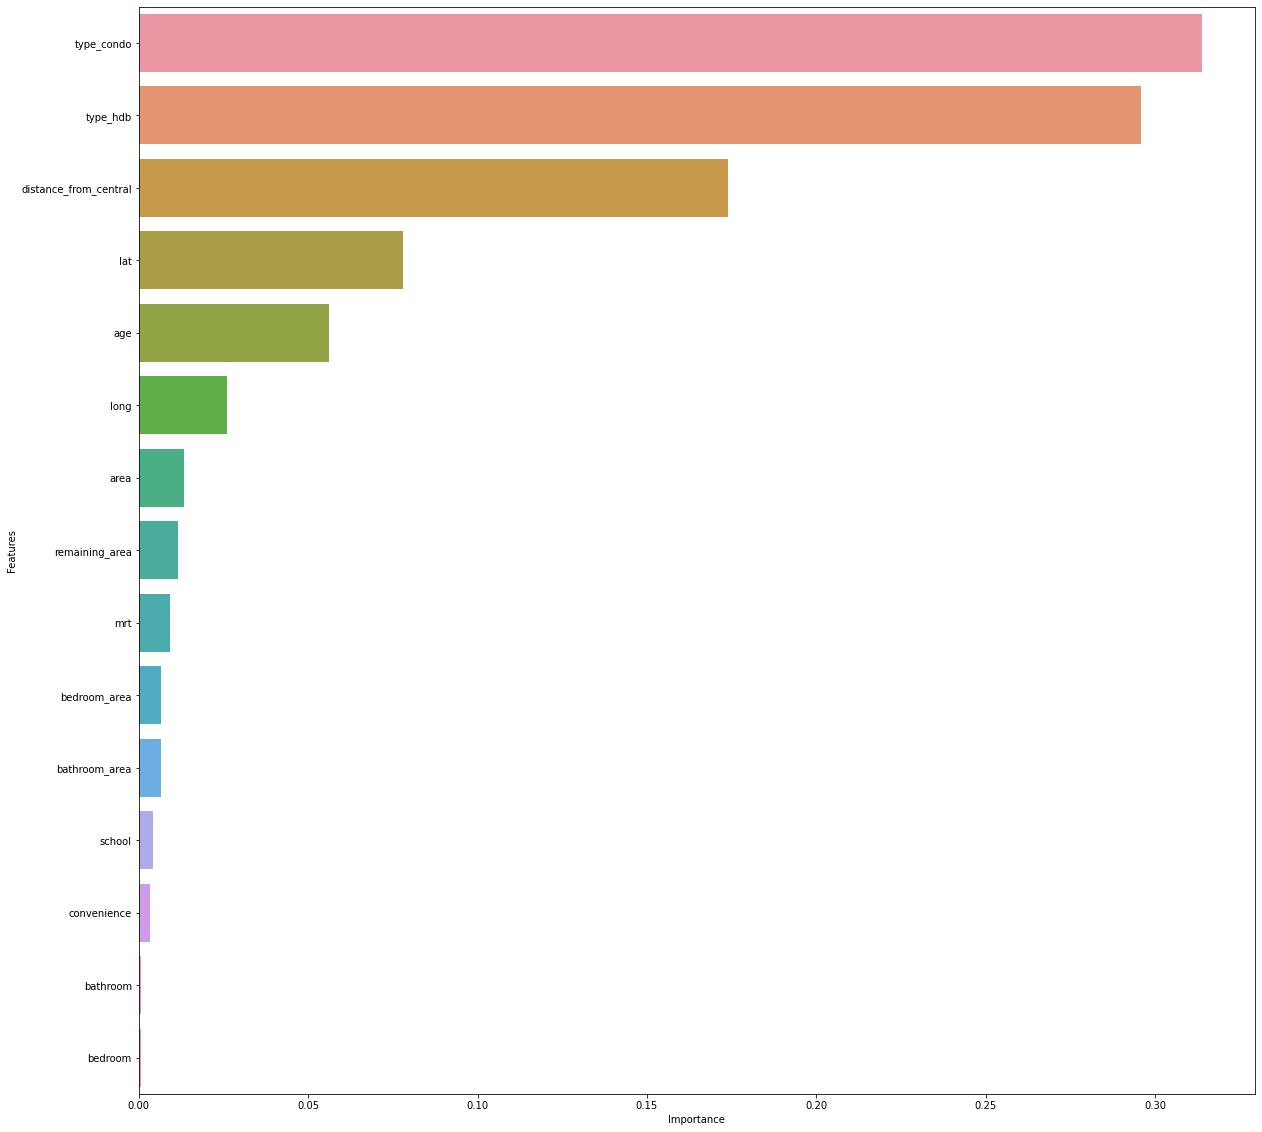

In [13]:
f,axes = plt.subplots(1,1,figsize=(20,20))
sb.barplot(x='Importance', y='Features', data=f_importance)

<p>It seems that the type of apartments is very important. This is followed by distance from central, age and the coordinates. These six features take up 94.4% of the decision made in the GradientBoosting tree</p>

#### Accuracy of RandomForestRegressor on Test set

In [126]:
test = pd.read_csv('data/test.csv')

print("RMSE for RF: ", rmse(rf.predict(test.iloc[:,:-1]), test.iloc[:,-1]))

RMSE for RF:  113.08566355834299


### 9.4. GradientBoostingRegressor <a name='gb'></a>
[Back to top](#Contents)<br>

#### Simple GradientBoostingRegressor

In [11]:
err = []

for train_idx, test_idx in kfold.split(train):
    train_x = train.iloc[train_idx, :-1]
    test_x = train.iloc[test_idx, :-1]

    train_y = train.iloc[train_idx, -1]
    test_y = train.iloc[test_idx, -1]
    
    gb = GradientBoostingRegressor()
    gb.fit(train_x, train_y)
    y_pred = rf.predict(test_x)
    err.append(rmse(y_pred, test_y))

print(err)
print(np.mean(err))

[66.4718339244947, 62.108474182277874, 183.85684343190366, 202.34113468278386, 203.4385766945657]
143.64337258320515


#### Hyperparameter selection for GBRegressor

In [14]:
param = {
    'subsample': [0.4,0.6,0.8,1.0],
    'max_depth': [3,6,9,12,15],
    'max_features': ['auto', 'log2', None] + list(np.arange(0.5, 1, 0.2)), # Maximum number of features to consider at each split
    'min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node
}

grid_search = GridSearchCV(GradientBoostingRegressor(n_estimators=500), param_grid=param, cv=5)
grid_search.fit(train.iloc[:,:-1], train.iloc[:,-1])
best_param = grid_search.best_params_

print(best_param)

{'max_depth': 12, 'max_features': 0.5, 'min_samples_split': 10, 'subsample': 1.0}


#### Accuracy of the Optimised Model

In [155]:
gb = GradientBoostingRegressor(n_estimators=500, max_depth=12, max_features=0.5, min_samples_split=10, subsample=1.0)

In [17]:
err = []

for train_idx, test_idx in kfold.split(train):
    train_x = train.iloc[train_idx, :-1]
    test_x = train.iloc[test_idx, :-1]

    train_y = train.iloc[train_idx, -1]
    test_y = train.iloc[test_idx, -1]
    
    gb.fit(train_x, train_y)
    y_pred = gb.predict(test_x)
    err.append(rmse(y_pred, test_y))

print(err)
print(np.mean(err))

[48.818204649762734, 44.85580148980461, 156.92585164480795, 162.57423650994718, 160.95833962356477]
114.82648678357745


In [156]:
gb.fit(train.iloc[:,:-1], train.iloc[:,-1])

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=12,
                          max_features=0.5, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#### Importance of each feature in the Gradient Boosting trees

In [43]:
f_importance = pd.DataFrame(columns=['Features', 'Importance'])
f_importance['Features'] = train.columns[:-1]
f_importance['Importance'] = gb.feature_importances_
f_importance.sort_values(by='Importance', inplace=True, ascending=False)
f_importance

,Features,Importance
14,type_hdb,0.522959
12,distance_from_central,0.144769
3,lat,0.091734
7,age,0.089811
13,type_condo,0.044252
4,long,0.036196
6,mrt,0.022147
10,remaining_area,0.011548
0,area,0.011408
8,bathroom_area,0.007570


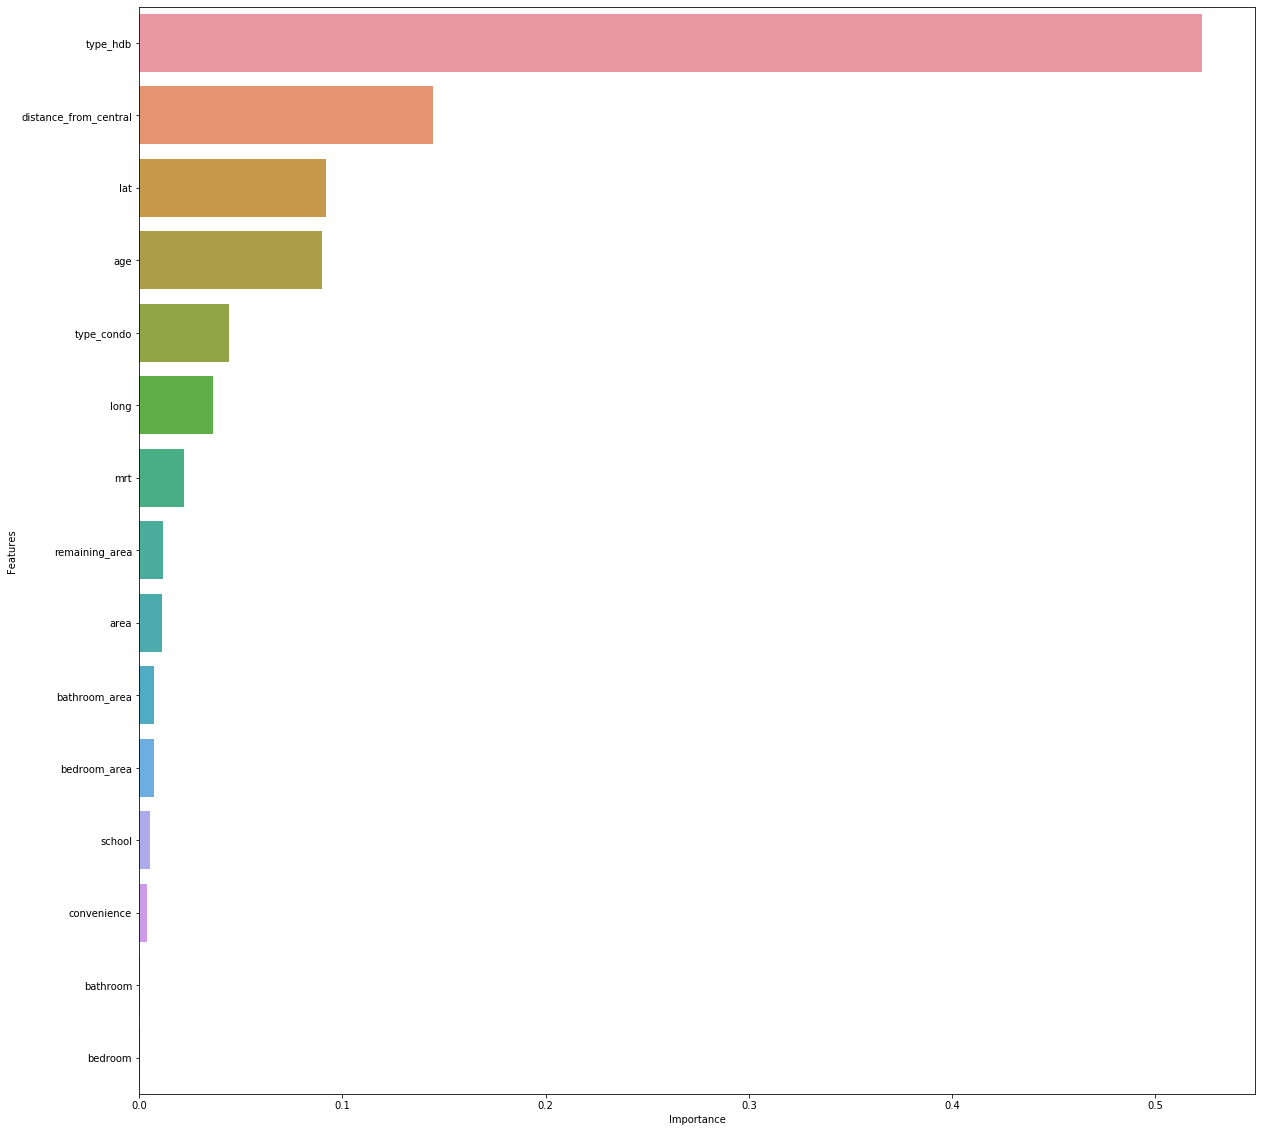

In [44]:
f,axes = plt.subplots(1,1,figsize=(20,20))
sb.barplot(x='Importance', y='Features', data=f_importance)

<p>It seems that the type of apartments is very important. This is followed by distance from central, age and the coordinates. These six features take up 93.0% of the decision made in the GradientBoosting tree</p>

#### Accuracy of GradientBoostingRegressor on Test set

In [157]:
test = pd.read_csv('data/test.csv')
print("RMSE for GB: ", rmse(gb.predict(test.iloc[:,:-1]), test.iloc[:,-1]))

RMSE for GB:  113.22359065428512


### 9.5. KNeighborsRegressor <a name='knn'></a>
[Back to top](#Contents)<br>

#### Simple KNeighborsRegressor

In [6]:
knn = KNeighborsRegressor()
err = []

for train_idx, test_idx in kfold.split(train):
    train_x = train.iloc[train_idx, :-1]
    test_x = train.iloc[test_idx, :-1]

    train_y = train.iloc[train_idx, -1]
    test_y = train.iloc[test_idx, -1]

    knn.fit(train_x, train_y)
    y_pred = knn.predict(test_x)
    err.append(rmse(y_pred, test_y))

print(err)
print(np.mean(err))

[98.71587979778246, 85.07751519659098, 246.19921948639916, 251.4279111882935, 246.4838796849063]
185.58088107079448


#### Hyperparameter selection for KNeighborsRegressor

In [9]:
param = {
    'n_neighbors': np.arange(5,30,5),
    'weights': ['uniform', 'distance'],
    'p': [1,2,3],
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid=param, cv=5)
grid_search.fit(train.iloc[:,:-1], train.iloc[:,-1])
best_param = grid_search.best_params_

print(best_param)

{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


C:\Users\TNG\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [131]:
knn = KNeighborsRegressor(n_neighbors=5, p=1, weights='distance')

In [12]:
err = []

for train_idx, test_idx in kfold.split(train):
    train_x = train.iloc[train_idx, :-1]
    test_x = train.iloc[test_idx, :-1]

    train_y = train.iloc[train_idx, -1]
    test_y = train.iloc[test_idx, -1]

    knn = KNeighborsRegressor(n_neighbors=5, p=1, weights='distance')
    knn.fit(train_x, train_y)
    y_pred = knn.predict(test_x)
    err.append(rmse(y_pred, test_y))

print(err)
print(np.mean(err))

[78.67688342818211, 62.17543516280433, 216.26837258801183, 218.41305295559536, 212.19835017626386]
157.5464188621715


#### Accuracy of KNeighborsRegressor on Test set

In [133]:
knn.fit(train.iloc[:,:-1], train.iloc[:,-1])
test = pd.read_csv('data/test.csv')

print("RMSE for RF: ", rmse(knn.predict(test.iloc[:,:-1]), test.iloc[:,-1]))

RMSE for RF:  163.27561410314317


#### Summary

Once again, this is the compiled results of the 5 regression models we have used.

<ul>
    <li>Linear/Polynomial: 255.754 (linear) / 194.313 (deg=3)</li>
    <li>Ridge: 164.977</li>
    <li>RandomForestRegressor: 113.085</li>
    <li>GradientBoostingRegressor: 113.223</li>
    <li>KNeighborsRegressor: 163.275</li>
</ul>

<p>The linear regression models have the highest errors, even with polynomial terms. KNeighbors did not perform well - the features might be too close to one another, preventing KNN from learning well.</p>

<p>The ensemble models perform the best.</p>

<p>Hence, with these 4 models (excluding Linear Regression), we try to improve our predictions by using another ensemble method. </p>

### 9.6. Stacking <a name='stacking'></a>
[Back to top](#Contents)<br>

<p>Stacking is an ensemble method based on collective intelligence.</p>
<p>First, we train the base models and obtain predicted values based on the validation set. Due to KFold, we will obtain predicted values (train_stack) for all training data, for all models. Next, we will use train_stack and the actual price to train our meta model. Then, we will propagate the test data through the whole stack and predict the housing price. Finally, we can evaluate our stacking ensemble with the root-mean-square-error.</p>

In [158]:
train_stack = pd.DataFrame(columns=['ridge', 'rf', 'grad', 'knn'], index=train.index)

### Training base models and the stacking model

In [159]:
poly = PolynomialFeatures(degree=3)

for train_idx, test_idx in kfold.split(train):
    
    train_x = train.iloc[train_idx, :-1]
    train_y = train.iloc[train_idx, -1]
    test_x = train.iloc[test_idx, :-1]
    test_y = train.iloc[test_idx, -1]
    
    train_x_poly = pd.DataFrame(poly.fit_transform(train_x.copy()), index=train_idx)
    test_x_poly = pd.DataFrame(poly.fit_transform(test_x.copy()), index=test_idx)
    
    # Train ridge
    ridge = Ridge(alpha=100)
    ridge.fit(train_x_poly, train_y)
    ridge_pred = ridge.predict(test_x_poly).reshape(-1,1)
    
    # Train RandomForestRegressor
    rf = RandomForestRegressor(max_depth=15, max_features=0.7, min_samples_split=2, n_estimators=250)
    rf.fit(train_x, train_y)
    rf_pred = rf.predict(test_x).reshape(-1,1)
    
    # Train GradientBoostingRegressor
    gb = GradientBoostingRegressor(n_estimators=500, max_depth=12, max_features=0.5, min_samples_split=10, subsample=1.0)
    gb.fit(train_x, train_y)
    gb_pred = gb.predict(test_x).reshape(-1,1)
    
    # Train KNeighborsRegressor
    knn =  KNeighborsRegressor(n_neighbors=5, p=1, weights='distance')
    knn.fit(train_x, train_y)
    knn_pred = knn.predict(test_x).reshape(-1,1)
    
    train_stack.iloc[test_idx] = np.concatenate((ridge_pred, rf_pred, gb_pred, knn_pred), axis=1)

In [160]:
meta = LinearRegression()
meta.fit(train_stack, train.iloc[:,-1])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [161]:
train_x = train.iloc[:, :-1]
train_y = train.iloc[:, -1]

train_x_poly = pd.DataFrame(poly.fit_transform(train_x.copy()), index=train.index)

# Train ridge
ridge = Ridge(alpha=100)
ridge.fit(train_x_poly, train_y)

# Train RandomForestRegressor
rf = RandomForestRegressor(max_depth=15, max_features=0.7, min_samples_split=2, n_estimators=250)
rf.fit(train_x, train_y)

# Train GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=500, max_depth=12, max_features=0.5, min_samples_split=10, subsample=1.0)
gb.fit(train_x, train_y)

# Train KNeighborsRegressor
knn =  KNeighborsRegressor(n_neighbors=5, p=1, weights='distance')
knn.fit(train_x, train_y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                    weights='distance')

In [162]:
# Saving the base and meta models

pickle.dump(ridge, open('model/object/ridge.pickle', 'wb'))
pickle.dump(rf, open('model/object/rf.pickle', 'wb'))
pickle.dump(gb, open('model/object/gb.pickle', 'wb'))
pickle.dump(knn, open('model/object/knn.pickle', 'wb'))
pickle.dump(meta, open('model/object/meta.pickle', 'wb'))

In [163]:
def predict(features):
    ridge = pickle.load(open('model/object/ridge.pickle', 'rb'))
    rf = pickle.load(open('model/object/rf.pickle', 'rb'))
    gb = pickle.load(open('model/object/gb.pickle', 'rb'))
    knn = pickle.load(open('model/object/knn.pickle', 'rb'))
    meta = pickle.load(open('model/object/meta.pickle', 'rb'))
    
    meta_test = pd.DataFrame(columns=['ridge', 'rf', 'gb', 'knn'], index=features.index)
    
    poly = PolynomialFeatures(degree=3)
    ridge_pred = ridge.predict(poly.fit_transform(features)).reshape(-1,1)
    rf_pred = rf.predict(features).reshape(-1,1)
    gb_pred = gb.predict(features).reshape(-1,1)
    knn_pred = knn.predict(features).reshape(-1,1)
    
    meta_test = np.concatenate((ridge_pred, rf_pred, gb_pred, knn_pred), axis=1)
    
    y_pred = meta.predict(meta_test)
    
    return y_pred

In [164]:
y_pred = predict(test.iloc[:,:-1])
rmse(y_pred, test.iloc[:,-1])

111.47383295880643

## 10. Conclusion <a name='conclusion'></a>
[Back to top](#Contents)<br>

The Root-mean-square error of the test data is <b>111.473</b>. This means that in average, for an apartment with 1000 sqft, the error is SGD 111,473. This result is not very good, although it can be used as a rough estimate of the price.

## 11. Future Work <a name='future-work'></a>
[Back to top](#Contents)<br>

<p>The stacking ensemble might not have worked well, as the Ridge Regression and KNeighborsRegressor are not comparable regressors as RandomForest and GradientBoosting. To further improve results, more base models can be used, or higher-level stacking can be implemented (i.e with neural network). </p>

<p>We feel that the features we obtained from the acquired data are not sufficient to predict the housing price well. We could consult domain experts for more information about the real-estate business, thus allowing us to seek for the more important features. With the help of domain experts, we can also better understand the features and able to feature more complicated, yet useful features that could be used for our models.</p>
    
<p>Last but not least, for any data science project, the more data we retrieve, the better our predicting models will get. Therefore, we could have scraped the website for more listings that are recent and relevant. </p>
